In [12]:
from platform import python_version
python_version()

'3.9.16'

In [13]:
!pip list

/bin/bash: pip: command not found


In [11]:
import astropy
astropy.__version__

'5.2.1'

In [10]:
from astroquery.ipac.ned import Ned
result_table = Ned.query_region("3c 273", radius=0.05 * u.deg)
result_table

No.,Object Name,RA,DEC,Type,Velocity,Redshift,Redshift Flag,Magnitude and Filter,Separation,References,Notes,Photometry Points,Positions,Redshift Points,Diameter Points,Associations
,,degrees,degrees,,km / s,,,,arcmin,,,,,,,
int32,str30,float64,float64,object,float64,float64,object,object,float64,int32,int32,int32,int32,int32,int32,int32
1,WISEA J122855.03+020309.1,187.22917,2.05222,*,--,--,,24.0R,2.923,1,0,24,3,0,0,0
2,SSTSL2 J122855.02+020313.7,187.22925,2.05381,IrS,--,--,,,2.919,0,0,8,1,0,0,0
3,SSTSL2 J122855.23+020341.5,187.23013,2.06154,IrS,--,--,,,2.917,0,0,7,1,0,0,0
4,SSTSL2 J122855.36+020346.9,187.23068,2.06304,IrS,--,--,,,2.904,0,0,7,1,0,0,0
5,SSTSL2 J122855.64+020239.1,187.23187,2.04421,IrS,--,--,,,2.804,0,0,8,1,0,0,0
6,SSTSL2 J122855.66+020407.1,187.23194,2.06864,IrS,--,--,,,2.924,0,0,8,1,0,0,0
7,SSTSL2 J122855.73+020232.2,187.23208,2.04222,*,--,--,,23.2R,2.815,1,0,10,2,0,0,0
8,SSTSL2 J122855.75+020245.2,187.23233,2.0459,IrS,--,--,,,2.761,0,0,8,1,0,0,0


In [14]:
import os
import sys
from subprocess import check_call

check_call([sys.executable, '-m' 'pip', 'install', '--user', '-U', 'pip'])

0

In [15]:
#check_call([sys.executable, '-mpip', 'install', '--user', '-U', 'alerce==1.2.0'])
#check_call([sys.executable, '-mpip', 'install', '--user', '-U', 'astro-ghost==0.2.3'])
#check_call([sys.executable, '-mpip', 'install', '--user', '-U', 'astro-ghost==0.2.7'])
#check_call([sys.executable, '-mpip', 'install', '--user', '-U', 'astro-ghost==2.0.8'])
check_call([sys.executable, '-mpip', 'install', '--user', '-U', 'astro-ghost==2.0.10'])
#check_call([sys.executable, '-mpip', 'install', '--user', '-U', 'opencv-python==4.7.0.72'])
#check_call([sys.executable, '-mpip', 'uninstall', '--user', '-U', 'astropy==5.3'])
#check_call([sys.executable, '-mpip', 'install', '--user', '-U', 'astropy==5.2.1'])

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 9.5 MB/s eta 0:00:001
  Attempting uninstall: astro-ghost
    Found existing installation: astro-ghost 2.0.8
    Uninstalling astro-ghost-2.0.8:
      Successfully uninstalled astro-ghost-2.0.8


0

In [1]:
import astro_ghost
astro_ghost.__version__

'2.0.10'

In [1]:
# LAISS Random Forest Classifier for Transient (Supernova) Anomaly Detection
# Written by Patrick Aleo

# Import all necessary packages
import antares.devkit as dk; dk.init()

from astropy.coordinates import SkyCoord  # High-level coordinates
from astropy.coordinates import ICRS, Galactic, FK4, FK5  # Low-level frames

import os
import sys
import time

from alerce.core import Alerce
alerce = Alerce()

import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from itertools import chain
from datetime import datetime
import tempfile

import astro_ghost
# from astro_ghost.PS1QueryFunctions import getAllPostageStamps
# from astro_ghost.TNSQueryFunctions import getTNSSpectra
# from astro_ghost.NEDQueryFunctions import getNEDSpectra
from astro_ghost.ghostHelperFunctions import getTransientHosts, getGHOST
# Throw RA/DEC into ghost with just DLR method, gentle starcut
# Sets environ var to find ghost.csv
# os.environ['GHOST_PATH'] = './host_info'
# Then don't use getGHOST(real=True, verbose=verbose)
#getGHOST(real=True,verbose=False)

from astropy import units as u
from astropy.coordinates import SkyCoord  # High-level coordinates
from astropy.coordinates import ICRS, Galactic, FK4, FK5  # Low-level frames

import sklearn.ensemble
from sklearn.ensemble import IsolationForest

from collections import Counter

from sklearn import preprocessing
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import classification_report
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from scipy.spatial import cKDTree
from sklearn.decomposition import PCA
from sklearn.decomposition import SparsePCA
from sklearn.ensemble import RandomForestClassifier

# # set random seed for consistent results
# import random
# random.seed(0)

import warnings
warnings.filterwarnings("ignore")

def get_alerce_class(output):
    """
    Given the top 'output' probabilities from Alerce's classifiers (lc_classifier, hierarchical_rf, stamp_classifier),
    return the best class (the one displayed on the webpage at https://alerce.online/object/, typically lc_classifier). 
    If not classified, return 'Not_classified'.
    """
    top_class = None
    for item in output:
        if item['ranking'] == 1:
            if top_class is None or \
               (item['classifier_name'] == 'lc_classifier' and \
                item['classifier_version'] == 'hierarchical_rf_1.1.0') or \
               (item['classifier_name'] == 'stamp_classifier' and \
                item['classifier_version'] == 'stamp_classifier_1.0.4' and \
                top_class['classifier_version'] != 'hierarchical_rf_1.1.0') or \
               (item['classifier_name'] == 'stamp_classifier' and \
                item['classifier_version'] == 'stamp_classifier_1.0.0' and \
                top_class['classifier_version'] not in ['hierarchical_rf_1.1.0', 'stamp_classifier_1.0.4']):
                top_class = item
    return top_class['class_name'] if top_class is not None else "Not_classified"

Loading ANTARES from /data0/sw/antares-kernel/lib/python3.9/site-packages/antares/__init__.py

        _    _   _ _____  _    ____  _____ ____
       / \  | \ | |_   _|/ \  |  _ \| ____/ ___|
      / _ \ |  \| | | | / _ \ | |_| |  _| \___ \\
     / ___ \| |\  | | |/ ___ \|  _ /| |___ ___| |
    /_/   \_\_| \_| |_/_/   \_\_| \_\_____|____/   v2.4.2
    
2023-07-04 07:59:27,199 - WARNING MainThread settings.py:setup_prometheus:124 - Prometheus failed to start with [Errno 98] Address already in use


Jaeger tracer already initialized, skipping


2023-07-04 07:59:27,377 - WARNING MainThread settings.py:setup_prometheus:124 - Prometheus failed to start with [Errno 98] Address already in use
Testing loading a random Locus with `dk.get_locus()`...
2023-07-04 07:59:30,714 - INFO MainThread settings.py:cassandra_session_factory:84 - Establishing connection to Cassandra
2023-07-04 07:59:31,922 - INFO MainThread settings.py:cassandra_session_factory:88 - Connection to Cassandra established
2023-07-04 07:59:31,923 - INFO MainThread settings.py:cassandra_session_factory:84 - Establishing connection to Cassandra
2023-07-04 07:59:33,181 - INFO MainThread settings.py:cassandra_session_factory:88 - Connection to Cassandra established
2023-07-04 07:59:33,183 - INFO MainThread settings.py:cassandra_session_factory:84 - Establishing connection to Cassandra
2023-07-04 07:59:34,289 - INFO MainThread settings.py:cassandra_session_factory:88 - Connection to Cassandra established


/data0/sw/antares-kernel/lib/python3.9/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)



ANTARES v2.4.2 DevKit is ready!
Website: https://antares.noirlab.edu
Documentation: https://nsf-noirlab.gitlab.io/csdc/antares/antares/



In [22]:
%time
class LAISS_RFC_AD_filter(dk.Filter):
    NAME = 'LAISS_RFC_AD_filter'
    ERROR_SLACK_CHANNEL = 'U0135TMN9UK'  # Patrick Aleo Slack member ID
    REQUIRES_FILES = [
    #    './paleo2_106IFmodel_472727objs_nest=1000_cont=0.001_transf.pkl', #106 feature Isolation Forest model
    #    './antares_norm.py' #py file for transforming ZTF alert feature values
        './data/database/',
    ]
    REQUIRED_LOCUS_PROPERTIES = [
        'ztf_object_id',
    ]
    REQUIRED_ALERT_PROPERTIES = [
    ]
    INPUT_TAGS = [
        'lc_feature_extractor'
    ]
    OUTPUT_LOCUS_PROPERTIES = [
          {
          'name': 'LAISS_RFC_anomaly_score',
          'type': 'float',
          'description': 'Calculated anomaly score. From RFC model, objects are tagged as anomalous if "Other" (anomaly) classification is >0.5 at any point during light curve evolution. If none calculated, set to TBD',
          },
    ]
    OUTPUT_ALERT_PROPERTIES = [
    ]
    OUTPUT_TAGS = [
        {
          'name': 'LAISS_RFC_AD_filter', 
          'description': 'The Light Curve AI Similarity Search (LAISS; Aleo et al in prep) random forest classifier anomaly detection filter aims to tag rare, exotic, and unusual transients (supernovae). It is an random forest classifier algorithm trained on upsampled (balanced classes) spectroscopic SNe using extracted light curve and host galaxy features.',
        },
    ]

    
    def setup(self):
        """
    #    ANTARES will call this function once at the beginning of each night
    #    when filters are loaded.
    #    """
        # Sets environ var to find ghost.csv
        #os.environ['GHOST_PATH'] = './data'
        #print(os.environ['GHOST_PATH'])
        # Then don't use getGHOST(real=True, verbose=verbose)
        #getGHOST(real=False,verbose=False)
        #print(os.environ['GHOST_PATH'])
        
        # Sets environ var to find ghost.csv
        os.environ['GHOST_PATH'] = './host_info'
        # Then don't use getGHOST(real=True, verbose=verbose)
        getGHOST(real=True,verbose=True)
        
        # From 106 available features from Kostya's lc_feature_extractor, use the 82 from SNAD Miner paper 
        # R and g bands
        self.feature_names_r_g = ['feature_amplitude_magn_r', 
                         'feature_anderson_darling_normal_magn_r',
                         'feature_beyond_1_std_magn_r', 
                         'feature_beyond_2_std_magn_r',
                         'feature_cusum_magn_r', 
                         #'feature_eta_e_magn_r',
                         'feature_inter_percentile_range_2_magn_r',
                         'feature_inter_percentile_range_10_magn_r',
                         'feature_inter_percentile_range_25_magn_r', 
                         'feature_kurtosis_magn_r',
                         'feature_linear_fit_slope_magn_r',
                         'feature_linear_fit_slope_sigma_magn_r',
                         #'feature_linear_fit_reduced_chi2_magn_r', 
                         #'feature_linear_trend_magn_r', # cadence removal
                         #'feature_linear_trend_sigma_magn_r',  # cadence removal
                         'feature_magnitude_percentage_ratio_40_5_magn_r',
                         'feature_magnitude_percentage_ratio_20_5_magn_r',
                         #'feature_maximum_slope_magn_r',
                         'feature_mean_magn_r',
                         'feature_median_absolute_deviation_magn_r',
                         'feature_percent_amplitude_magn_r',
                         'feature_median_buffer_range_percentage_10_magn_r',
                         'feature_median_buffer_range_percentage_20_magn_r',
                         'feature_percent_difference_magnitude_percentile_5_magn_r',
                         'feature_percent_difference_magnitude_percentile_10_magn_r',
                         #'feature_period_0_magn_r',  # should be negated
                         #'feature_period_s_to_n_0_magn_r', # cadence removal
                         #'feature_period_1_magn_r', 
                         #'feature_period_s_to_n_1_magn_r', # cadence removal
                         #'feature_period_2_magn_r', 
                         #'feature_period_s_to_n_2_magn_r', # cadence removal
                         #'feature_period_3_magn_r', 
                         #'feature_period_s_to_n_3_magn_r', # cadence removal
                         #'feature_period_4_magn_r', 
                         #'feature_period_s_to_n_4_magn_r', # cadence removal
                         #'feature_periodogram_amplitude_magn_r',
                         #'feature_periodogram_beyond_2_std_magn_r',  # cadence removal
                         #'feature_periodogram_beyond_3_std_magn_r',  # cadence removal
                         #'feature_periodogram_standard_deviation_magn_r',   # cadence removal
                         #'feature_chi2_magn_r',
                         'feature_skew_magn_r', 
                         'feature_standard_deviation_magn_r',
                         'feature_stetson_k_magn_r',
                         'feature_weighted_mean_magn_r',
                         'feature_anderson_darling_normal_flux_r', 
                         'feature_cusum_flux_r',
                         #'feature_eta_e_flux_r', 
                         'feature_excess_variance_flux_r',
                         'feature_kurtosis_flux_r', 
                         'feature_mean_variance_flux_r',
                         #'feature_chi2_flux_r', 
                         'feature_skew_flux_r',
                         'feature_stetson_k_flux_r',

                         'feature_amplitude_magn_g', 
                         'feature_anderson_darling_normal_magn_g',
                         'feature_beyond_1_std_magn_g', 
                         'feature_beyond_2_std_magn_g',
                         'feature_cusum_magn_g', 
                         #'feature_eta_e_magn_g',
                         'feature_inter_percentile_range_2_magn_g',
                         'feature_inter_percentile_range_10_magn_g',
                         'feature_inter_percentile_range_25_magn_g', 
                         'feature_kurtosis_magn_g',
                         'feature_linear_fit_slope_magn_g',
                         'feature_linear_fit_slope_sigma_magn_g',
                         #'feature_linear_fit_reduced_chi2_magn_g', 
                         #'feature_linear_trend_magn_g', # cadence removal
                         #'feature_linear_trend_sigma_magn_g',  # cadence removal
                         'feature_magnitude_percentage_ratio_40_5_magn_g',
                         'feature_magnitude_percentage_ratio_20_5_magn_g',
                         #'feature_maximum_slope_magn_g', 
                         'feature_mean_magn_g',
                         'feature_median_absolute_deviation_magn_g',
                         'feature_median_buffer_range_percentage_10_magn_g',
                         'feature_median_buffer_range_percentage_20_magn_g',
                         'feature_percent_amplitude_magn_g',
                         'feature_percent_difference_magnitude_percentile_5_magn_g',
                         'feature_percent_difference_magnitude_percentile_10_magn_g',
                         #'feature_period_0_magn_g',  # should be negated
                         #'feature_period_s_to_n_0_magn_g', # cadence removal
                         #'feature_period_1_magn_g', 
                         #'feature_period_s_to_n_1_magn_g', # cadence removal
                         #'feature_period_2_magn_g', 
                         #'feature_period_s_to_n_2_magn_g', # cadence removal
                         #'feature_period_3_magn_g', 
                         #'feature_period_s_to_n_3_magn_g', # cadence removal
                         #'feature_period_4_magn_g', 
                         #'feature_period_s_to_n_4_magn_g', # cadence removal
                         #'feature_periodogram_amplitude_magn_g',
                         #'feature_periodogram_beyond_2_std_magn_g',  # cadence removal
                         #'feature_periodogram_beyond_3_std_magn_g', # cadence removal
                         #'feature_periodogram_standard_deviation_magn_g',  # cadence removal
                         #'feature_chi2_magn_g',
                         'feature_skew_magn_g', 
                         'feature_standard_deviation_magn_g',
                         'feature_stetson_k_magn_g', 
                         'feature_weighted_mean_magn_g',
                         'feature_anderson_darling_normal_flux_g', 
                         'feature_cusum_flux_g',
                         #'feature_eta_e_flux_g', 
                         'feature_excess_variance_flux_g',
                         'feature_kurtosis_flux_g', 
                         'feature_mean_variance_flux_g',
                         #'feature_chi2_flux_g', 
                         'feature_skew_flux_g',
                         'feature_stetson_k_flux_g']   
        
        self.feature_names_hostgal = [
            #  'Unnamed: 0',
            #  'level_0',
            #  'index',
            #  'objName',
            #  'objAltName1',
            #  'objAltName2',
            #  'objAltName3',
            #  'objID',
            #  'uniquePspsOBid',
            #  'ippObjID',
            #  'surveyID',
            #  'htmID',
            #  'zoneID',
            #  'tessID',
            #  'projectionID',
            #  'skyCellID',
            #  'randomID',
            #  'batchID',
            #  'dvoRegionID',
            #  'processingVersion',
            #  'objInfoFlag',
            #  'qualityFlag',
            #  'raStack',
            #  'decStack',
            #  'raStackErr',
            #  'decStackErr',
            #  'raMean',
            #  'decMean',
            #  'raMeanErr',
            #  'decMeanErr',
            #  'epochMean',
            #  'posMeanChisq',
            #  'cx',
            #  'cy',
            #  'cz',
            #  'lambda',
            #  'beta',
            #  'l',
            #  'b',
            #  'nStackObjectRows',
            #  'nStackDetections',
            #  'nDetections',
            #  'ng',
            #  'nr',
            #  'ni',
            #  'nz',
            #  'ny',
            #  'uniquePspsSTid',
            #  'primaryDetection',
            #  'bestDetection',
            #  'gippDetectID',
            #  'gstackDetectID',
            #  'gstackImageID',
            #  'gra',
            #  'gdec',
            #  'graErr',
            #  'gdecErr',
            #  'gEpoch',
            #  'gPSFMag',
            #  'gPSFMagErr',
            #  'gApMag',
            #  'gApMagErr',
            #  'gKronMag',
            #  'gKronMagErr',
            #  'ginfoFlag',
            #  'ginfoFlag2',
            #  'ginfoFlag3',
            #  'gnFrames',
            #  'gxPos',
            #  'gyPos',
            #  'gxPosErr',
            #  'gyPosErr',
            #  'gpsfMajorFWHM',
            #  'gpsfMinorFWHM',
            #  'gpsfTheta',
            #  'gpsfCore',
            #  'gpsfLikelihood',
            #  'gpsfQf',
            #  'gpsfQfPerfect',
            #  'gpsfChiSq',
             'gmomentXX',
             'gmomentXY',
             'gmomentYY',
             'gmomentR1',
             'gmomentRH',
             'gPSFFlux',
            #  'gPSFFluxErr',
             'gApFlux',
            #  'gApFluxErr',
            #  'gApFillFac',
            #  'gApRadius',
             'gKronFlux',
            #  'gKronFluxErr',
             'gKronRad',
            #  'gexpTime',
             'gExtNSigma',
            #  'gsky',
            #  'gskyErr',
            #  'gzp',
            #  'gPlateScale',
            #  'rippDetectID',
            #  'rstackDetectID',
            #  'rstackImageID',
            #  'rra',
            #  'rdec',
            #  'rraErr',
            #  'rdecErr',
            #  'rEpoch',
            # 'rPSFMag',
            #  'rPSFMagErr',
            # 'rApMag',
            #  'rApMagErr',
            # 'rKronMag',
            #  'rKronMagErr',
            #  'rinfoFlag',
            #  'rinfoFlag2',
            #  'rinfoFlag3',
            #  'rnFrames',
            #  'rxPos',
            #  'ryPos',
            #  'rxPosErr',
            #  'ryPosErr',
            #  'rpsfMajorFWHM',
            #  'rpsfMinorFWHM',
            #  'rpsfTheta',
            #  'rpsfCore',
            #  'rpsfLikelihood',
            #  'rpsfQf',
            #  'rpsfQfPerfect',
            #  'rpsfChiSq',
             'rmomentXX',
             'rmomentXY',
             'rmomentYY',
             'rmomentR1',
             'rmomentRH',
            'rPSFFlux',
            #  'rPSFFluxErr',
            'rApFlux',
            #  'rApFluxErr',
            #  'rApFillFac',
            # 'rApRadius',
            'rKronFlux',
            #  'rKronFluxErr',
            'rKronRad',
            #  'rexpTime',
             'rExtNSigma',
            #  'rsky',
            #  'rskyErr',
            #  'rzp',
            #  'rPlateScale',
            #  'iippDetectID',
            #  'istackDetectID',
            #  'istackImageID',
            #  'ira',
            #  'idec',
            #  'iraErr',
            #  'idecErr',
            #  'iEpoch',
            #  'iPSFMag',
            #  'iPSFMagErr',
            #  'iApMag',
            #  'iApMagErr',
            #  'iKronMag',
            #  'iKronMagErr',
            #  'iinfoFlag',
            #  'iinfoFlag2',
            #  'iinfoFlag3',
            #  'inFrames',
            #  'ixPos',
            #  'iyPos',
            #  'ixPosErr',
            #  'iyPosErr',
            #  'ipsfMajorFWHM',
            #  'ipsfMinorFWHM',
            #  'ipsfTheta',
            #  'ipsfCore',
            #  'ipsfLikelihood',
            #  'ipsfQf',
            #  'ipsfQfPerfect',
            #  'ipsfChiSq',
              'imomentXX',
             'imomentXY',
             'imomentYY',
             'imomentR1',
             'imomentRH',
             'iPSFFlux',
            #  'iPSFFluxErr',
             'iApFlux',
            #  'iApFluxErr',
            #  'iApFillFac',
            #  'iApRadius',
             'iKronFlux',
            #  'iKronFluxErr',
             'iKronRad',
            #  'iexpTime',
              'iExtNSigma',
            #  'isky',
            #  'iskyErr',
            #  'izp',
            #  'iPlateScale',
            #  'zippDetectID',
            #  'zstackDetectID',
            #  'zstackImageID',
            #  'zra',
            #  'zdec',
            #  'zraErr',
            #  'zdecErr',
            #  'zEpoch',
            #  'zPSFMag',
            #  'zPSFMagErr',
            #  'zApMag',
            #  'zApMagErr',
            #  'zKronMag',
            #  'zKronMagErr',
            #  'zinfoFlag',
            #  'zinfoFlag2',
            #  'zinfoFlag3',
            #  'znFrames',
            #  'zxPos',
            #  'zyPos',
            #  'zxPosErr',
            #  'zyPosErr',
            #  'zpsfMajorFWHM',
            #  'zpsfMinorFWHM',
            #  'zpsfTheta',
            #  'zpsfCore',
            #  'zpsfLikelihood',
            #  'zpsfQf',
            #  'zpsfQfPerfect',
            #  'zpsfChiSq',
              'zmomentXX',
             'zmomentXY',
             'zmomentYY',
             'zmomentR1',
             'zmomentRH',
             'zPSFFlux',
            # #  'zPSFFluxErr',
             'zApFlux',
            # #  'zApFluxErr',
            # #  'zApFillFac',
            # #  'zApRadius',
             'zKronFlux',
            # #  'zKronFluxErr',
             'zKronRad',
            # #  'zexpTime',
              'zExtNSigma',
            #  'zsky',
            #  'zskyErr',
            #  'zzp',
            #  'zPlateScale',
            #  'yippDetectID',
            #  'ystackDetectID',
            #  'ystackImageID',
            #  'yra',
            #  'ydec',
            #  'yraErr',
            #  'ydecErr',
            #  'yEpoch',
            #  'yPSFMag',
            #  'yPSFMagErr',
            #  'yApMag',
            #  'yApMagErr',
            #  'yKronMag',
            #  'yKronMagErr',
            #  'yinfoFlag',
            #  'yinfoFlag2',
            #  'yinfoFlag3',
            #  'ynFrames',
            #  'yxPos',
            #  'yyPos',
            #  'yxPosErr',
            #  'yyPosErr',
            #  'ypsfMajorFWHM',
            #  'ypsfMinorFWHM',
            #  'ypsfTheta',
            #  'ypsfCore',
            #  'ypsfLikelihood',
            #  'ypsfQf',
            #  'ypsfQfPerfect',
            #  'ypsfChiSq',
              'ymomentXX',
              'ymomentXY',
              'ymomentYY',
              'ymomentR1',
              'ymomentRH',
              'yPSFFlux',
            # #   'yPSFFluxErr',
              'yApFlux',
            # #   'yApFluxErr',
            # #   'yApFillFac',
            # #  'yApRadius',
             'yKronFlux',
            # #  'yKronFluxErr',
             'yKronRad',
            # #  'yexpTime',
              'yExtNSigma',
            #  'ysky',
            #  'yskyErr',
            #  'yzp',
            #  'yPlateScale',
            #  'distance',
            #  'SkyMapper_StarClass',
            #  'gelong',
            #  'g_a',
            #  'g_b',
            #  'g_pa',
            #  'relong',
            #  'r_a',
            #  'r_b',
            #  'r_pa',
            #  'ielong',
            #  'i_a',
            #  'i_b',
            #  'i_pa',
            #  'zelong',
            #  'z_a',
            #  'z_b',
            #  'z_pa',
               'i-z', # try throwing in
            #    'g-r',
            #    'r-i',
            #    'g-i',
            #    'z-y',
            #   'g-rErr',
            #   'r-iErr',
            #   'i-zErr',
            #   'z-yErr',
             'gApMag_gKronMag',
             'rApMag_rKronMag',
             'iApMag_iKronMag',
             'zApMag_zKronMag',
             'yApMag_yKronMag',
             '7DCD', 
            #  'NED_name',
            #  'NED_type',
            #  'NED_vel',
            #  'NED_redshift',
            #  'NED_mag',
            #  'class',
               'dist/DLR',
            #   'dist',
            #  'TransientClass',
            #  'TransientRA',
            #  'TransientDEC'
               ]
        
#         # Load 106 feature IF model at beginning of the night and store it. 
#         #self.IF_model = self.files['./paleo2_106IFmodel_472727objs_nest=1000_cont=0.001_transf.pkl']
#         with open('./paleo2_106IFmodel_472727objs_nest=1000_cont=0.001_transf.pkl', 'rb') as f: #not imported right way
#             self.clf = pickle.load(f)
        
#         # Return the model to use in run(self, locus)
#         return self.clf


        n_estimators=100 
        max_depth=35 
        random_state=11
        max_features=35
        with open(f'./model/cls=binary_n_estimators={n_estimators}_max_depth={max_depth}_rs={random_state}_max_feats={max_features}_cw=balanced.pkl', 'rb') as f:
            self.clf = pickle.load(f)

        return self

    def run(self, locus):
        """
        Send alerts to stream 'LAISS_RFC_AD_filter' if alert was received from 'lc_feature_extractor' filter,
        assigned an anomaly score from trained RFC model (requires both R, g bands),
        and passes strict masking requirement to filter out unwanted periodic objects to maximise anomalous,
        transient events. 
        """
        print("##############")
        # Required: if the loci has passed through the 'lc_feature_extractor' filter
        if 'lc_feature_extractor' in locus.tags:
            
            # from locus info, get ra,dec and cut on objs in galactic plane
            loci_coord = SkyCoord(locus.ra*u.deg, 
                                     locus.dec*u.deg, 
                                     frame="icrs", 
                                     unit='deg')
            loci_galcoord = loci_coord.galactic
            # cut on anything in galactic plane
            if np.abs(loci_galcoord.b.degree) < 15:
                print(f"In galactic plane at b={loci_galcoord.b.degree}. Don't use. Skip!")
                return

            # Make dictionary. Make keys ZTF IDs
            locus_dict = {}
            ztf_id = locus.properties['ztf_object_id']
            print(f"Processing https://alerce.online/object/{ztf_id}")
            # Get extracted LC feature values from ANTARES db
            try:
                locus_dict[ztf_id] = [locus.properties[feature] for feature in self.feature_names_r_g]
            except:
                print(f"Only one passband of LC feature data for {ztf_id}. Skip!")
                return
            loci_df = pd.DataFrame.from_dict(locus_dict).T
            loci_df.columns = self.feature_names_r_g

            # Drop row if any feature values are nan
            loci_df = loci_df[~loci_df[self.feature_names_r_g].isnull().any(axis=1)]
            loci_df['TransientName'] = ztf_id
            loci_df = loci_df.set_index('TransientName')
            
            if len(loci_df) < 1:
                print(f"Had NaN features. Must drop {ztf_id}. Skip!")
                return
            
            #print(loci_df)
            
            # Query for Alerce best classifier result (i.e. what is displayed on the object page)
            try:
                probabilities = alerce.query_probabilities(ztf_id)
                alerce_cls = get_alerce_class(probabilities)
                print("alerce_cls", alerce_cls)
            except:
                print(f"Error getting best alerce classifier result for {ztf_id}. Skip!")
                alerce_cls = 'Error'
                return
            
            # If Alerce's classifier does not say SN, don't consider this object
            # Cuts many stars, AGN, etc. that are outside of galactic plane
            if not alerce_cls.startswith('S'): 
                # Alerce LC classifier possible classes: 
                #   ['AGN', 'Blazar', 'CEP', 'CV/Nova', 'DSCT', 'E', 'Error', 'LPV',
                #  'Not_classified', 'Periodic-Other', 'QSO', 'RRL', 'SLSN', 'SN',
                #   'SNII', 'SNIa', 'SNIbc', 'VS', 'YSO', 'asteroid', 'bogus']
                
                # Alerce Stamp classifier possible classes:
                #   ['AGN', 'asteroid', 'bogus, 'SN', 'VS']
                print(f"Alerce class={alerce_cls} is not SN ('SLSN', 'SN', 'SNII', 'SNIa', 'SNIbc') for {ztf_id}. Skip!")
                return
            
            # Passed first round of cuts.
            # Now, get GHOST host association for host galaxy features.
            with tempfile.TemporaryDirectory() as tmp:
                
                #TODO: in future, save GHOST events. And then if obj has GHOST host features,
                # then don't run again b/c host won't change...
                
                try: 
                    # in new version, snName -> transientName
                    hosts_df = getTransientHosts(transientName=[ztf_id], snCoord=[loci_coord], GLADE=True, verbose=1, starcut='gentle', 
                                              ascentMatch=False, savepath=tmp, redo_search=True)
                    print(f'http://ps1images.stsci.edu/cgi-bin/ps1cutouts?pos={hosts_df.raMean.values[0]}+{hosts_df.decMean.values[0]}&filter=color')
                    hosts_df = hosts_df.set_index('TransientName')
                    #print(list(hosts_df.columns))
                    #print(set(list(self.feature_names_hostgal)) - set(list(hosts_df.columns)))
                    hosts_df = hosts_df[self.feature_names_hostgal]
                    #print(hosts_df)
                    
                except:
                    print(f"GHOST host association fails for {ztf_id}. Skip!")
                    return
            # Got a GHOST host association. 
            # Match PS1 objIDs from GHOST into PS1 PSC, 
            # and cut to only retain extended sources (galaxies) at location of the host (not transient).
            
            # TODO, but ps1-psc is ~18GBs, so make sure it's ok w/ ANTARES before downloading
            # For now, move on...    
                
            # Combine LC and host galaxy features into one dataframe.
            # We will use this as input into RFC!
            lc_and_hosts_df = pd.concat([loci_df, hosts_df], axis=1)
            #lc_and_hosts_df['dist/DLR'] = np.nan # To test NaN features        
            lc_and_hosts_df = lc_and_hosts_df[~lc_and_hosts_df.isnull().any(axis=1)]

            if len(lc_and_hosts_df) < 1:
                # if any features are nan, we can't use as input
                print(f"Some features are NaN for {ztf_id}. Skip!")
                return

            
            #print(lc_and_hosts_df) 
            anom_thresh = 50 # 50% thresh for 'Anomaly' or 'Other' class
            try:
                pred_prob_anom = 100 * self.clf.predict_proba(lc_and_hosts_df)
                num_anom_epochs = len(np.where(pred_prob_anom[:, 1]>=anom_thresh)[0])
                #print("pred_prob_anom", pred_prob_anom)
                #print("Len", len(pred_prob_anom))
            except:
                print(f"Something wrong when fitting the model for {ztf_id}. Skip!")
                return

            if round(pred_prob_anom[:, 1][0], 2) < anom_thresh:
                print(f"{ztf_id} is NOT anomalous according to RFC model (anom score={round(pred_prob_anom[:, 1][0], 2)}%). Skip!")
                return
            
            else: 
                # Assign locus property saving anomaly score
                locus.properties['LAISS_RFC_anomaly_score'] = round(pred_prob_anom[:, 1][0], 2)
                print(f"{ztf_id} is ANOMALOUS! LAISS_RFC_anomaly_score={round(pred_prob_anom[:, 1][0], 2)}%")

                # Plot since passed anomaly threshold
                df_ref = locus.timeseries.to_pandas()

                df_ref_g = df_ref[(df_ref.ant_passband == 'g') & (~df_ref.ant_mag.isna())]
                df_ref_r = df_ref[(df_ref.ant_passband == 'R') & (~df_ref.ant_mag.isna())]

                mjd_idx_at_min_mag_r_ref = df_ref_r[['ant_mag']].reset_index().idxmin().ant_mag
                mjd_idx_at_min_mag_g_ref = df_ref_g[['ant_mag']].reset_index().idxmin().ant_mag

                fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(5,7))
                ax1.invert_yaxis()
                ax1.errorbar(x=df_ref_r.ant_mjd, y=df_ref_r.ant_mag, yerr=df_ref_r.ant_magerr, fmt='o', c='r', 
                            label=f'REF: {ztf_id}')
                ax1.errorbar(x=df_ref_g.ant_mjd, y=df_ref_g.ant_mag, yerr=df_ref_g.ant_magerr, fmt='o', c='g')
                if df_ref_g.ant_mjd[-1] < df_ref_r.ant_mjd[-1]:
                    ax1.axvline(x=df_ref_r.ant_mjd[-1], c='#ff7f0e')
                else: ax1.axvline(x=df_ref_g.ant_mjd[-1], c='#ff7f0e')
                #ax1.set_xlim(min(df_ref_r.ant_mjd), max(df_ref_r.ant_mjd))

                print(f'https://alerce.online/object/{ztf_id}')
                ax2.scatter(df_ref_r.ant_mjd[-1], pred_prob_anom[:, 0], label='p(Normal)')
                ax2.scatter(df_ref_r.ant_mjd[-1], pred_prob_anom[:, 1], label='p(Other)')
                ax2.axhline(y=anom_thresh, c='k', ls='--')



                ax2.set_ylim(0,100)
                plt.xlabel('ant_mjd')
                plt.ylabel('Probability (%)')
                plt.legend()
                plt.show()


                # TAG Locus if passed anomaly threshold!
                locus.tag('LAISS_RFC_AD_filter')
                    

        else:
            locus.properties['anomaly_type'] = 'TBD'
            pass

CPU times: user 9 µs, sys: 0 ns, total: 9 µs
Wall time: 20.3 µs


In [31]:
%%time
#report = dk.run_filter(LAISS_RFC_AD_filter, locus='ANT2020aes3osq') # SLSN - yes anom
#report = dk.run_filter(LAISS_RFC_AD_filter, locus='ANT2022a6ub4') # Faint SN - no anom
#report = dk.run_filter(LAISS_RFC_AD_filter, locus='ANT2022azfzi') # SN - no anom
#report = dk.run_filter(LAISS_RFC_AD_filter, locus='ANT20235wlqblnn7mgp') # Bright Ia - no anom
#report = dk.run_filter(LAISS_RFC_AD_filter, locus='ANT2020ae6pkcy') # Ic that's anom - ghost features don't return the right ones from SIMBAD hierarchical stuff
# - now wrong host assoc
#report = dk.run_filter(LAISS_RFC_AD_filter, locus='ANT20202oqw4') # Ic that's anom - is GLADE but doesn't return right PS1 features - 0.2.10 updates fixes it!
#report = dk.run_filter(LAISS_RFC_AD_filter, locus='ANT2021cydny') # IIn that's anom
#report = dk.run_filter(LAISS_RFC_AD_filter, locus='ANT2023wo615uyufi6e') # 2023kqw - has enough obs but not lc_feature_extractor???
#report = dk.run_filter(LAISS_RFC_AD_filter, locus='ANT2023gw31ziyqzwdw') # 2023gpw - some host features NaN
#report = dk.run_filter(LAISS_RFC_AD_filter, locus='ANT2018dl52m') # Star - galactic plane
#report = dk.run_filter(LAISS_RFC_AD_filter, locus='ANT2019nogmu') # Star - not in galactic plane

report = dk.run_filter(LAISS_RFC_AD_filter, locus='ANT2021i7jbu') # 2021hpr

#report = dk.run_filter(LAISS_RFC_AD_filter)
print(report)

Span has already been finished; will not be reported again.


GHOST database already exists in the install path!
##############
Processing https://alerce.online/object/ZTF21aarqkes
alerce_cls SNIa
1 transients not found in GHOST by name, trying a coordinate search...
1 transients not found in GHOST by name or coordinates, manually associating...
Found 1 hosts in GLADE! See gladeDLR.txt for details.
Warning! Host of ZTF21aarqkes is the hierarchical child of another object in Simbad, choosing parent as host instead...
Found matches for 100.0% of events.
Saving table of hosts to /tmp/tmp40s7zsuutransients_20230704092156177320/tables/FinalAssociationTable.csv.
0 transients found by name, 0 transients found by coordinates, 1 transients manually associated.
http://ps1images.stsci.edu/cgi-bin/ps1cutouts?pos=154.10708956+73.36285704&filter=color
Some features are NaN for ZTF21aarqkes. Skip!
{'locus_id': 'ANT2021i7jbu', 'locus_data': FilterContext(locus_id="ANT2021i7jbu"), 't': 3.462991503000012, 'new_locus_properties': {}, 'new_alert_properties': {}, 'ne

Span has already been finished; will not be reported again.


GHOST database already exists in the install path!
##############
In galactic plane at b=12.453769591179459. Don't use. Skip!


Span has already been finished; will not be reported again.


GHOST database already exists in the install path!
2023-07-04 09:11:40,931 - WARNING MainThread cassandra.py:list_by_location:1187 - Catalog object not found (catalog_id=19, object_id=767849552)
##############
Processing https://alerce.online/object/ZTF22aarpwpj
alerce_cls Blazar
Alerce class=Blazar is not SN ('SLSN', 'SN', 'SNII', 'SNIa', 'SNIbc') for ZTF22aarpwpj. Skip!


Span has already been finished; will not be reported again.


GHOST database already exists in the install path!
##############
Processing https://alerce.online/object/ZTF23aakhjuz
alerce_cls SNIbc
1 transients not found in GHOST by name, trying a coordinate search...
1 transients not found in GHOST by name or coordinates, manually associating...
Found no hosts in GLADE.
Finding northern sources with Pan-starrs...
Associated fraction after quality cuts: 100.00%.
Loading model Star_Galaxy_RealisticModel_GHOST_PS1ClassLabels.sav.
Removed 7 stars. We now have 13 candidate host galaxies.
Found matches for 100.0% of events.
Saving table of hosts to /tmp/tmpdgvpfhzvtransients_20230704091155538398/tables/FinalAssociationTable.csv.
0 transients found by name, 0 transients found by coordinates, 1 transients manually associated.
http://ps1images.stsci.edu/cgi-bin/ps1cutouts?pos=263.34870468+51.16505455&filter=color
ZTF23aakhjuz is NOT anomalous according to RFC model (anom score=37.0%). Skip!


[Parallel(n_jobs=40)]: Using backend ThreadingBackend with 40 concurrent workers.
[Parallel(n_jobs=40)]: Done 100 out of 100 | elapsed:    0.0s finished
Span has already been finished; will not be reported again.


GHOST database already exists in the install path!
##############
Processing https://alerce.online/object/ZTF23aagdbbv
alerce_cls QSO
Alerce class=QSO is not SN ('SLSN', 'SN', 'SNII', 'SNIa', 'SNIbc') for ZTF23aagdbbv. Skip!


Span has already been finished; will not be reported again.


GHOST database already exists in the install path!
##############
Processing https://alerce.online/object/ZTF23aahjfab
alerce_cls SNIa
1 transients not found in GHOST by name, trying a coordinate search...
1 transients not found in GHOST by name or coordinates, manually associating...
Found no hosts in GLADE.
Finding northern sources with Pan-starrs...
Associated fraction after quality cuts: 100.00%.
Loading model Star_Galaxy_RealisticModel_GHOST_PS1ClassLabels.sav.
Removed 14 stars. We now have 9 candidate host galaxies.
Found matches for 100.0% of events.
Saving table of hosts to /tmp/tmp9561qfhvtransients_20230704091206925847/tables/FinalAssociationTable.csv.
0 transients found by name, 0 transients found by coordinates, 1 transients manually associated.
http://ps1images.stsci.edu/cgi-bin/ps1cutouts?pos=262.79435469+29.62719334&filter=color
ZTF23aahjfab is NOT anomalous according to RFC model (anom score=29.0%). Skip!


[Parallel(n_jobs=40)]: Using backend ThreadingBackend with 40 concurrent workers.
[Parallel(n_jobs=40)]: Done 100 out of 100 | elapsed:    0.0s finished
Span has already been finished; will not be reported again.


GHOST database already exists in the install path!
##############
Processing https://alerce.online/object/ZTF22abmubfr
alerce_cls SLSN
1 transients not found in GHOST by name, trying a coordinate search...
1 transients not found in GHOST by name or coordinates, manually associating...
Found no hosts in GLADE.
Finding northern sources with Pan-starrs...
Associated fraction after quality cuts: 100.00%.
Loading model Star_Galaxy_RealisticModel_GHOST_PS1ClassLabels.sav.
Removed 18 stars. We now have 12 candidate host galaxies.
Found matches for 100.0% of events.
Saving table of hosts to /tmp/tmpjb4g7r2htransients_20230704091215027321/tables/FinalAssociationTable.csv.
0 transients found by name, 0 transients found by coordinates, 1 transients manually associated.
http://ps1images.stsci.edu/cgi-bin/ps1cutouts?pos=326.50542262+30.84118273&filter=color
ZTF22abmubfr is NOT anomalous according to RFC model (anom score=43.99%). Skip!


[Parallel(n_jobs=40)]: Using backend ThreadingBackend with 40 concurrent workers.
[Parallel(n_jobs=40)]: Done 100 out of 100 | elapsed:    0.0s finished
Span has already been finished; will not be reported again.


GHOST database already exists in the install path!
##############
Processing https://alerce.online/object/ZTF17aabtvsy
alerce_cls SNIa
1 transients not found in GHOST by name, trying a coordinate search...
1 transients not found in GHOST by name or coordinates, manually associating...
Found 1 hosts in GLADE! See gladeDLR.txt for details.
GHOST host association fails for ZTF17aabtvsy. Skip!


Span has already been finished; will not be reported again.


GHOST database already exists in the install path!
##############
Processing https://alerce.online/object/ZTF22abfdzrv
alerce_cls SLSN
1 transients not found in GHOST by name, trying a coordinate search...
1 transients not found in GHOST by name or coordinates, manually associating...
Found no hosts in GLADE.
Finding northern sources with Pan-starrs...
Associated fraction after quality cuts: 100.00%.
Loading model Star_Galaxy_RealisticModel_GHOST_PS1ClassLabels.sav.
Removed 9 stars. We now have 7 candidate host galaxies.
Found matches for 0.0% of events.
Saving table of hosts to /tmp/tmp7x7qal4atransients_20230704091230567064/tables/FinalAssociationTable.csv.
Couldn't find any hosts! Trying again with a search radius of 150''.
Found no hosts in GLADE.
Finding northern sources with Pan-starrs...
Associated fraction after quality cuts: 100.00%.
Loading model Star_Galaxy_RealisticModel_GHOST_PS1ClassLabels.sav.
Removed 50 stars. We now have 48 candidate host galaxies.
Desperate match foun

[Parallel(n_jobs=40)]: Using backend ThreadingBackend with 40 concurrent workers.
[Parallel(n_jobs=40)]: Done 100 out of 100 | elapsed:    0.0s finished


https://alerce.online/object/ZTF22abfdzrv


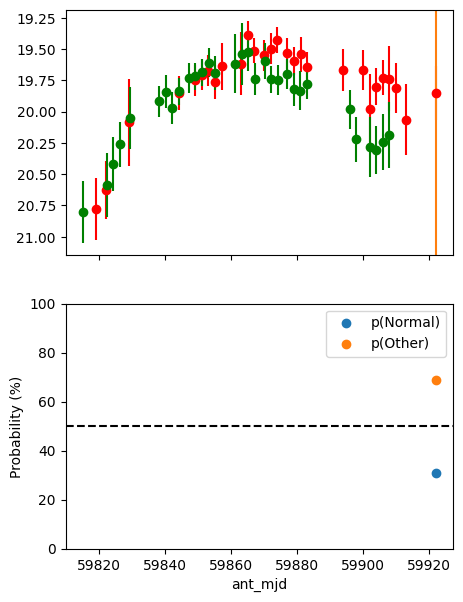

Span has already been finished; will not be reported again.


GHOST database already exists in the install path!
##############
Processing https://alerce.online/object/ZTF22aapjqpn
alerce_cls SLSN
1 transients not found in GHOST by name, trying a coordinate search...
1 transients not found in GHOST by name or coordinates, manually associating...
Found no hosts in GLADE.
Finding northern sources with Pan-starrs...
Associated fraction after quality cuts: 100.00%.
Loading model Star_Galaxy_RealisticModel_GHOST_PS1ClassLabels.sav.
Removed 7 stars. We now have 5 candidate host galaxies.
Found matches for 0.0% of events.
Saving table of hosts to /tmp/tmpgqysvf3rtransients_20230704091251748297/tables/FinalAssociationTable.csv.
Couldn't find any hosts! Trying again with a search radius of 150''.
Found no hosts in GLADE.
Finding northern sources with Pan-starrs...
Associated fraction after quality cuts: 100.00%.
Loading model Star_Galaxy_RealisticModel_GHOST_PS1ClassLabels.sav.
Removed 63 stars. We now have 26 candidate host galaxies.
Found matches for 0.

Span has already been finished; will not be reported again.


GHOST database already exists in the install path!
##############
Processing https://alerce.online/object/ZTF22aapkbkl
alerce_cls SLSN
1 transients not found in GHOST by name, trying a coordinate search...
1 transients not found in GHOST by name or coordinates, manually associating...
Found no hosts in GLADE.
Finding northern sources with Pan-starrs...
Associated fraction after quality cuts: 100.00%.
Loading model Star_Galaxy_RealisticModel_GHOST_PS1ClassLabels.sav.
Removed 2 stars. We now have 7 candidate host galaxies.
Desperate match found for ZTF22aapkbkl, 49.33 arcsec away.
Found matches for 100.0% of events.
Saving table of hosts to /tmp/tmp01umhn0_transients_20230704091307815664/tables/FinalAssociationTable.csv.
0 transients found by name, 0 transients found by coordinates, 1 transients manually associated.
http://ps1images.stsci.edu/cgi-bin/ps1cutouts?pos=356.4045722+29.63976879&filter=color
Some features are NaN for ZTF22aapkbkl. Skip!
CPU times: user 52.9 s, sys: 2.61 s, tota

In [24]:
%%time
locus_l = ['ANT2023qm4kk6rumag1','ANT2023aq21pb8wwx9h','ANT2023lwkizc214v3c','ANT2023qqx12rcysbiu','ANT2023hprgweyn8fyx',
           'ANT2022y495anna579h','ANT20223vl41wbwvauh','ANT2022kru0dw8kijis','ANT202297goejtz3so3','ANT20225fx7wc8r3nvv']
for loc in locus_l:
    report = dk.run_filter(LAISS_RFC_AD_filter, locus=loc)

In [4]:
%%time

# run LAISS_RFC_AD_filter on n random Locus Ids
report = dk.run_many(LAISS_RFC_AD_filter, n=100)

print(report)

Span has already been finished; will not be reported again.


GHOST database already exists in the install path!
In galactic plane at b=-2.9069279443027964. Don't use. Skip!
In galactic plane at b=-4.016961770457901. Don't use. Skip!
In galactic plane at b=-1.904470200438129. Don't use. Skip!
In galactic plane at b=-6.483210251323878. Don't use. Skip!
Locus ANT2019pry2y skipped because it doesn't satisfy the filter constraints: a property is not in the Locus's input_properties or alert properties or an input_tag is not in the Locus's input_tags.
In galactic plane at b=-1.1728040497514767. Don't use. Skip!
In galactic plane at b=-0.3491050903378238. Don't use. Skip!
In galactic plane at b=-1.461311185741395. Don't use. Skip!
In galactic plane at b=-2.752541426153285. Don't use. Skip!



KeyboardInterrupt



In [20]:
astro_ghost.__version__

'2.0.10'

In [21]:
import astropy
astropy.__version__

'5.2.1'

In [5]:
%%time
import antares_client
# Get all IF AD objects, use that as input and see what would be anomalous
tags = "iso_forest_anomaly_detection"

query = {
    "query": {
        "term": {
            "tags": tags
        }
    }
}
#loci = antares_client.search.search(query)
#locus_ids = [l.locus_id for l in loci]

loci = antares_client.search.search(query)
loci = list(loci)
locus_ids = [l.locus_id for l in loci]
locus_ids

CPU times: user 1min 44s, sys: 2.72 s, total: 1min 47s
Wall time: 5min 55s


['ANT2019zm34o',
 'ANT2020vn226',
 'ANT2019f4h3k',
 'ANT2020nbolq',
 'ANT2019zm3wm',
 'ANT2019oyskg',
 'ANT2020ywskc',
 'ANT2019t2t56',
 'ANT2020bd7ck',
 'ANT2020a5224',
 'ANT2019vca4y',
 'ANT2019ymwmo',
 'ANT2020aertkyq',
 'ANT2020djdng',
 'ANT2020jos4c',
 'ANT2020dlmie',
 'ANT2020runso',
 'ANT20234hadr3mv1nfu',
 'ANT2023kgeeduds81mi',
 'ANT2021r5crq',
 'ANT2021nwkkm',
 'ANT2020fbg56',
 'ANT2020aeocu',
 'ANT2020bu6y6',
 'ANT2022baf2q',
 'ANT2021n6vqe',
 'ANT2020mtiyy',
 'ANT2020bkguy',
 'ANT2022lwpa',
 'ANT2020vtja',
 'ANT2021comuk',
 'ANT2020apqjq',
 'ANT2022bjoz6',
 'ANT2021coeua',
 'ANT2020bh2jy',
 'ANT2020a6pum',
 'ANT2020a7szm',
 'ANT2021pvdf2',
 'ANT2020batk6',
 'ANT2019kvaa4',
 'ANT2022hj3ipo2puuz0',
 'ANT2022xwz1lpmrmd9d',
 'ANT20232ayv46d65eit',
 'ANT2022ch7uy',
 'ANT2021p7nki',
 'ANT2023zw1b5a1q2spa',
 'ANT2021ly5nu',
 'ANT2021hv4ku',
 'ANT2020bfaj6',
 'ANT2019fpoog',
 'ANT2020and4y',
 'ANT2023mdw73nvg43y9',
 'ANT2022ggua',
 'ANT2021mkgei',
 'ANT2021inye6',
 'ANT2023x11t0uhb

In [6]:
len(locus_ids)

10000

In [12]:
%%time

for loc in locus_ids[0:25]:
    report = dk.run_filter(LAISS_RFC_AD_filter, locus=loc)

Span has already been finished; will not be reported again.


GHOST database already exists in the install path!
##############
Processing https://alerce.online/object/ZTF18aaaatyb
alerce_cls RRL
Alerce class=RRL is not SN ('SLSN', 'SN', 'SNII', 'SNIa', 'SNIbc') for ZTF18aaaatyb. Skip!


Span has already been finished; will not be reported again.


GHOST database already exists in the install path!
##############
Processing https://alerce.online/object/ZTF18acmyftf
alerce_cls CEP
Alerce class=CEP is not SN ('SLSN', 'SN', 'SNII', 'SNIa', 'SNIbc') for ZTF18acmyftf. Skip!


Span has already been finished; will not be reported again.


GHOST database already exists in the install path!
##############
In galactic plane at b=-11.915105900611811. Don't use. Skip!


Span has already been finished; will not be reported again.


GHOST database already exists in the install path!
##############
Processing https://alerce.online/object/ZTF20abjgexp
alerce_cls VS
Alerce class=VS is not SN ('SLSN', 'SN', 'SNII', 'SNIa', 'SNIbc') for ZTF20abjgexp. Skip!


Span has already been finished; will not be reported again.


GHOST database already exists in the install path!
##############
In galactic plane at b=-12.904354757068349. Don't use. Skip!


Span has already been finished; will not be reported again.


GHOST database already exists in the install path!
##############
Processing https://alerce.online/object/ZTF18abynqqi
alerce_cls E
Alerce class=E is not SN ('SLSN', 'SN', 'SNII', 'SNIa', 'SNIbc') for ZTF18abynqqi. Skip!


Span has already been finished; will not be reported again.


GHOST database already exists in the install path!
2023-07-04 08:37:38,133 - WARNING MainThread cassandra.py:list_by_location:1187 - Catalog object not found (catalog_id=19, object_id=975903156)
##############
Processing https://alerce.online/object/ZTF19accfzym
alerce_cls Periodic-Other
Alerce class=Periodic-Other is not SN ('SLSN', 'SN', 'SNII', 'SNIa', 'SNIbc') for ZTF19accfzym. Skip!


Span has already been finished; will not be reported again.


GHOST database already exists in the install path!
##############
Processing https://alerce.online/object/ZTF18aayeocn
alerce_cls E
Alerce class=E is not SN ('SLSN', 'SN', 'SNII', 'SNIa', 'SNIbc') for ZTF18aayeocn. Skip!


Span has already been finished; will not be reported again.


GHOST database already exists in the install path!
##############
Processing https://alerce.online/object/ZTF18aazrdpr
alerce_cls CV/Nova
Alerce class=CV/Nova is not SN ('SLSN', 'SN', 'SNII', 'SNIa', 'SNIbc') for ZTF18aazrdpr. Skip!


Span has already been finished; will not be reported again.


GHOST database already exists in the install path!
##############
Processing https://alerce.online/object/ZTF18abaeanl
alerce_cls E
Alerce class=E is not SN ('SLSN', 'SN', 'SNII', 'SNIa', 'SNIbc') for ZTF18abaeanl. Skip!


Span has already been finished; will not be reported again.


GHOST database already exists in the install path!
##############
Processing https://alerce.online/object/ZTF18aaoechc
alerce_cls E
Alerce class=E is not SN ('SLSN', 'SN', 'SNII', 'SNIa', 'SNIbc') for ZTF18aaoechc. Skip!


Span has already been finished; will not be reported again.


GHOST database already exists in the install path!
##############
Processing https://alerce.online/object/ZTF18aaoebrc
alerce_cls CV/Nova
Alerce class=CV/Nova is not SN ('SLSN', 'SN', 'SNII', 'SNIa', 'SNIbc') for ZTF18aaoebrc. Skip!


Span has already been finished; will not be reported again.


GHOST database already exists in the install path!
##############
Processing https://alerce.online/object/ZTF18aavqaey
alerce_cls Periodic-Other
Alerce class=Periodic-Other is not SN ('SLSN', 'SN', 'SNII', 'SNIa', 'SNIbc') for ZTF18aavqaey. Skip!


Span has already been finished; will not be reported again.


GHOST database already exists in the install path!
##############
Processing https://alerce.online/object/ZTF18adjjftt
alerce_cls Periodic-Other
Alerce class=Periodic-Other is not SN ('SLSN', 'SN', 'SNII', 'SNIa', 'SNIbc') for ZTF18adjjftt. Skip!


Span has already been finished; will not be reported again.


GHOST database already exists in the install path!
##############
Processing https://alerce.online/object/ZTF18aamgnkt
alerce_cls CV/Nova
Alerce class=CV/Nova is not SN ('SLSN', 'SN', 'SNII', 'SNIa', 'SNIbc') for ZTF18aamgnkt. Skip!


Span has already been finished; will not be reported again.


GHOST database already exists in the install path!
##############
Processing https://alerce.online/object/ZTF18aarwlve
alerce_cls E
Alerce class=E is not SN ('SLSN', 'SN', 'SNII', 'SNIa', 'SNIbc') for ZTF18aarwlve. Skip!


Span has already been finished; will not be reported again.


GHOST database already exists in the install path!
##############
Processing https://alerce.online/object/ZTF19abraqix
alerce_cls SNII
Finding northern sources with Pan-starrs...
Found matches for 0.0% of events.
Found no hosts in GLADE.
Finding northern sources with Pan-starrs...
Found matches for 100.0% of events.
http://ps1images.stsci.edu/cgi-bin/ps1cutouts?pos=266.99729816+64.76273163&filter=color
Some features are NaN for ZTF19abraqix. Skip!


Span has already been finished; will not be reported again.


GHOST database already exists in the install path!
##############
Processing https://alerce.online/object/ZTF23aagpjyp
alerce_cls SLSN
Finding northern sources with Pan-starrs...
Found matches for 100.0% of events.
http://ps1images.stsci.edu/cgi-bin/ps1cutouts?pos=272.9856314+52.84142229&filter=color
ZTF23aagpjyp is NOT anomalous according to RFC model (anom score=23.0%). Skip!


[Parallel(n_jobs=40)]: Using backend ThreadingBackend with 40 concurrent workers.
[Parallel(n_jobs=40)]: Done 100 out of 100 | elapsed:    0.0s finished
Span has already been finished; will not be reported again.


GHOST database already exists in the install path!
##############
In galactic plane at b=14.294633134653125. Don't use. Skip!


Span has already been finished; will not be reported again.


GHOST database already exists in the install path!
##############
In galactic plane at b=12.848595662924344. Don't use. Skip!


Span has already been finished; will not be reported again.


GHOST database already exists in the install path!
##############
In galactic plane at b=10.381790750351751. Don't use. Skip!


Span has already been finished; will not be reported again.


GHOST database already exists in the install path!
2023-07-04 08:38:46,724 - WARNING MainThread cassandra.py:list_by_location:1187 - Catalog object not found (catalog_id=19, object_id=861212779)
##############
Processing https://alerce.online/object/ZTF18ablvxfm
alerce_cls CV/Nova
Alerce class=CV/Nova is not SN ('SLSN', 'SN', 'SNII', 'SNIa', 'SNIbc') for ZTF18ablvxfm. Skip!


Span has already been finished; will not be reported again.


GHOST database already exists in the install path!
2023-07-04 08:38:54,426 - WARNING MainThread cassandra.py:list_by_location:1187 - Catalog object not found (catalog_id=19, object_id=878527307)
##############
In galactic plane at b=-14.973976317653504. Don't use. Skip!


Span has already been finished; will not be reported again.


GHOST database already exists in the install path!
2023-07-04 08:38:57,234 - WARNING MainThread cassandra.py:list_by_location:1187 - Catalog object not found (catalog_id=19, object_id=815343256)
##############
In galactic plane at b=-13.612888047197147. Don't use. Skip!


Span has already been finished; will not be reported again.


GHOST database already exists in the install path!
2023-07-04 08:38:59,828 - WARNING MainThread cassandra.py:list_by_location:1187 - Catalog object not found (catalog_id=19, object_id=534630551)
##############
Processing https://alerce.online/object/ZTF20abbhbvu
alerce_cls Periodic-Other
Alerce class=Periodic-Other is not SN ('SLSN', 'SN', 'SNII', 'SNIa', 'SNIbc') for ZTF20abbhbvu. Skip!
CPU times: user 36.9 s, sys: 921 ms, total: 37.8 s
Wall time: 1min 53s


In [13]:
%%time

for loc in locus_ids[25:50]:
    report = dk.run_filter(LAISS_RFC_AD_filter, locus=loc)

Span has already been finished; will not be reported again.


GHOST database already exists in the install path!
2023-07-04 08:40:09,064 - WARNING MainThread cassandra.py:list_by_location:1187 - Catalog object not found (catalog_id=19, object_id=750265595)
##############
Processing https://alerce.online/object/ZTF18abastzj
alerce_cls RRL
Alerce class=RRL is not SN ('SLSN', 'SN', 'SNII', 'SNIa', 'SNIbc') for ZTF18abastzj. Skip!


Span has already been finished; will not be reported again.


GHOST database already exists in the install path!
2023-07-04 08:40:11,557 - WARNING MainThread cassandra.py:list_by_location:1187 - Catalog object not found (catalog_id=19, object_id=712615473)
##############
Processing https://alerce.online/object/ZTF20ablxmdq
alerce_cls SNII
Finding northern sources with Pan-starrs...
Found matches for 100.0% of events.
http://ps1images.stsci.edu/cgi-bin/ps1cutouts?pos=324.59467763+8.80418091&filter=color
ZTF20ablxmdq is NOT anomalous according to RFC model (anom score=25.0%). Skip!


[Parallel(n_jobs=40)]: Using backend ThreadingBackend with 40 concurrent workers.
[Parallel(n_jobs=40)]: Done 100 out of 100 | elapsed:    0.0s finished
Span has already been finished; will not be reported again.


GHOST database already exists in the install path!
##############
In galactic plane at b=13.583212331855544. Don't use. Skip!


Span has already been finished; will not be reported again.


GHOST database already exists in the install path!
##############
Processing https://alerce.online/object/ZTF18adixgbp
alerce_cls CEP
Alerce class=CEP is not SN ('SLSN', 'SN', 'SNII', 'SNIa', 'SNIbc') for ZTF18adixgbp. Skip!


Span has already been finished; will not be reported again.


GHOST database already exists in the install path!
2023-07-04 08:40:26,540 - WARNING MainThread cassandra.py:list_by_location:1187 - Catalog object not found (catalog_id=19, object_id=873413975)
##############
Processing https://alerce.online/object/ZTF18aakzrci
alerce_cls E
Alerce class=E is not SN ('SLSN', 'SN', 'SNII', 'SNIa', 'SNIbc') for ZTF18aakzrci. Skip!


Span has already been finished; will not be reported again.


GHOST database already exists in the install path!
2023-07-04 08:40:29,510 - WARNING MainThread cassandra.py:list_by_location:1187 - Catalog object not found (catalog_id=19, object_id=835532086)
##############
In galactic plane at b=12.797722014437658. Don't use. Skip!


Span has already been finished; will not be reported again.


GHOST database already exists in the install path!
##############
In galactic plane at b=14.66795195729818. Don't use. Skip!


Span has already been finished; will not be reported again.


GHOST database already exists in the install path!
##############
Processing https://alerce.online/object/ZTF18abcvvlc
alerce_cls LPV
Alerce class=LPV is not SN ('SLSN', 'SN', 'SNII', 'SNIa', 'SNIbc') for ZTF18abcvvlc. Skip!


Span has already been finished; will not be reported again.


GHOST database already exists in the install path!
2023-07-04 08:40:37,707 - WARNING MainThread cassandra.py:list_by_location:1187 - Catalog object not found (catalog_id=19, object_id=750594052)
##############
Processing https://alerce.online/object/ZTF18abcvvol
alerce_cls E
Alerce class=E is not SN ('SLSN', 'SN', 'SNII', 'SNIa', 'SNIbc') for ZTF18abcvvol. Skip!


Span has already been finished; will not be reported again.


GHOST database already exists in the install path!
2023-07-04 08:40:40,416 - WARNING MainThread cassandra.py:list_by_location:1187 - Catalog object not found (catalog_id=19, object_id=521332688)
##############
In galactic plane at b=10.274522217291123. Don't use. Skip!


Span has already been finished; will not be reported again.


GHOST database already exists in the install path!
2023-07-04 08:40:43,580 - WARNING MainThread cassandra.py:list_by_location:1187 - Catalog object not found (catalog_id=19, object_id=745191455)
##############
In galactic plane at b=10.850129574826967. Don't use. Skip!


Span has already been finished; will not be reported again.


GHOST database already exists in the install path!
2023-07-04 08:40:46,792 - WARNING MainThread cassandra.py:list_by_location:1187 - Catalog object not found (catalog_id=19, object_id=766289058)
##############
In galactic plane at b=11.834696926569078. Don't use. Skip!


Span has already been finished; will not be reported again.


GHOST database already exists in the install path!
2023-07-04 08:40:49,417 - WARNING MainThread cassandra.py:list_by_location:1187 - Catalog object not found (catalog_id=19, object_id=73119362)
##############
Processing https://alerce.online/object/ZTF21abflnwh
alerce_cls Blazar
Alerce class=Blazar is not SN ('SLSN', 'SN', 'SNII', 'SNIa', 'SNIbc') for ZTF21abflnwh. Skip!


Span has already been finished; will not be reported again.


GHOST database already exists in the install path!
2023-07-04 08:40:54,240 - WARNING MainThread cassandra.py:list_by_location:1187 - Catalog object not found (catalog_id=19, object_id=221979239)
##############
Processing https://alerce.online/object/ZTF18abwvgbb
alerce_cls RRL
Alerce class=RRL is not SN ('SLSN', 'SN', 'SNII', 'SNIa', 'SNIbc') for ZTF18abwvgbb. Skip!


Span has already been finished; will not be reported again.


GHOST database already exists in the install path!
2023-07-04 08:40:56,558 - WARNING MainThread cassandra.py:list_by_location:1187 - Catalog object not found (catalog_id=19, object_id=140801407)
##############
Processing https://alerce.online/object/ZTF19abdlcso
alerce_cls Periodic-Other
Alerce class=Periodic-Other is not SN ('SLSN', 'SN', 'SNII', 'SNIa', 'SNIbc') for ZTF19abdlcso. Skip!


Span has already been finished; will not be reported again.


GHOST database already exists in the install path!
##############
Processing https://alerce.online/object/ZTF22abztcly
alerce_cls SLSN
Finding northern sources with Pan-starrs...
Found matches for 0.0% of events.
Found no hosts in GLADE.
Finding northern sources with Pan-starrs...
Found matches for 0.0% of events.
GHOST host association fails for ZTF22abztcly. Skip!


Span has already been finished; will not be reported again.


GHOST database already exists in the install path!
##############
Processing https://alerce.online/object/ZTF22aazaypq
alerce_cls SNII
Finding northern sources with Pan-starrs...
Found matches for 100.0% of events.
http://ps1images.stsci.edu/cgi-bin/ps1cutouts?pos=290.7824474+81.08441561&filter=color
ZTF22aazaypq is NOT anomalous according to RFC model (anom score=28.0%). Skip!


[Parallel(n_jobs=40)]: Using backend ThreadingBackend with 40 concurrent workers.
[Parallel(n_jobs=40)]: Done 100 out of 100 | elapsed:    0.0s finished
Span has already been finished; will not be reported again.


GHOST database already exists in the install path!
##############
In galactic plane at b=12.991041387251927. Don't use. Skip!


Span has already been finished; will not be reported again.


GHOST database already exists in the install path!
##############
In galactic plane at b=13.635829023563165. Don't use. Skip!


Span has already been finished; will not be reported again.


GHOST database already exists in the install path!
##############
Processing https://alerce.online/object/ZTF21aawqhga
alerce_cls QSO
Alerce class=QSO is not SN ('SLSN', 'SN', 'SNII', 'SNIa', 'SNIbc') for ZTF21aawqhga. Skip!


Span has already been finished; will not be reported again.


GHOST database already exists in the install path!
##############
In galactic plane at b=11.213558833159848. Don't use. Skip!


Span has already been finished; will not be reported again.


GHOST database already exists in the install path!
2023-07-04 08:41:33,021 - WARNING MainThread cassandra.py:list_by_location:1187 - Catalog object not found (catalog_id=19, object_id=734013873)
##############
Processing https://alerce.online/object/ZTF18abcuvwm
alerce_cls E
Alerce class=E is not SN ('SLSN', 'SN', 'SNII', 'SNIa', 'SNIbc') for ZTF18abcuvwm. Skip!


Span has already been finished; will not be reported again.


GHOST database already exists in the install path!
2023-07-04 08:41:36,580 - WARNING MainThread cassandra.py:list_by_location:1187 - Catalog object not found (catalog_id=19, object_id=948450544)
##############
Processing https://alerce.online/object/ZTF17aabvflc
alerce_cls RRL
Alerce class=RRL is not SN ('SLSN', 'SN', 'SNII', 'SNIa', 'SNIbc') for ZTF17aabvflc. Skip!


Span has already been finished; will not be reported again.


GHOST database already exists in the install path!
##############
In galactic plane at b=10.752016518123757. Don't use. Skip!


Span has already been finished; will not be reported again.


GHOST database already exists in the install path!
2023-07-04 08:41:42,025 - WARNING MainThread cassandra.py:list_by_location:1187 - Catalog object not found (catalog_id=19, object_id=213970404)
##############
Processing https://alerce.online/object/ZTF19abhuchu
alerce_cls VS
Alerce class=VS is not SN ('SLSN', 'SN', 'SNII', 'SNIa', 'SNIbc') for ZTF19abhuchu. Skip!
CPU times: user 39.2 s, sys: 1.16 s, total: 40.3 s
Wall time: 1min 47s


Span has already been finished; will not be reported again.


GHOST database already exists in the install path!
2023-07-04 08:43:53,152 - WARNING MainThread cassandra.py:list_by_location:1187 - Catalog object not found (catalog_id=19, object_id=584373732)
##############
In galactic plane at b=10.95774433756741. Don't use. Skip!


Span has already been finished; will not be reported again.


GHOST database already exists in the install path!
2023-07-04 08:43:55,191 - WARNING MainThread cassandra.py:list_by_location:1187 - Catalog object not found (catalog_id=19, object_id=565099187)
##############
In galactic plane at b=13.140684770887509. Don't use. Skip!


Span has already been finished; will not be reported again.


GHOST database already exists in the install path!
2023-07-04 08:43:57,243 - WARNING MainThread cassandra.py:list_by_location:1187 - Catalog object not found (catalog_id=19, object_id=657521240)
##############
Processing https://alerce.online/object/ZTF18abiycou
alerce_cls Periodic-Other
Alerce class=Periodic-Other is not SN ('SLSN', 'SN', 'SNII', 'SNIa', 'SNIbc') for ZTF18abiycou. Skip!


Span has already been finished; will not be reported again.


GHOST database already exists in the install path!
2023-07-04 08:44:00,190 - WARNING MainThread cassandra.py:list_by_location:1187 - Catalog object not found (catalog_id=19, object_id=243175711)
##############
Processing https://alerce.online/object/ZTF21aaxwpyx
alerce_cls Blazar
Alerce class=Blazar is not SN ('SLSN', 'SN', 'SNII', 'SNIa', 'SNIbc') for ZTF21aaxwpyx. Skip!


Span has already been finished; will not be reported again.


GHOST database already exists in the install path!
##############
Processing https://alerce.online/object/ZTF20abjyage
alerce_cls Periodic-Other
Alerce class=Periodic-Other is not SN ('SLSN', 'SN', 'SNII', 'SNIa', 'SNIbc') for ZTF20abjyage. Skip!


Span has already been finished; will not be reported again.


GHOST database already exists in the install path!
##############
Processing https://alerce.online/object/ZTF23aaiwvdh
alerce_cls SNII
Finding northern sources with Pan-starrs...
Found matches for 100.0% of events.
http://ps1images.stsci.edu/cgi-bin/ps1cutouts?pos=258.44839188+70.57965072&filter=color
ZTF23aaiwvdh is NOT anomalous according to RFC model (anom score=19.0%). Skip!


[Parallel(n_jobs=40)]: Using backend ThreadingBackend with 40 concurrent workers.
[Parallel(n_jobs=40)]: Done 100 out of 100 | elapsed:    0.0s finished
Span has already been finished; will not be reported again.


GHOST database already exists in the install path!
##############
Processing https://alerce.online/object/ZTF18abkalak
alerce_cls VS
Alerce class=VS is not SN ('SLSN', 'SN', 'SNII', 'SNIa', 'SNIbc') for ZTF18abkalak. Skip!


Span has already been finished; will not be reported again.


GHOST database already exists in the install path!
##############
Processing https://alerce.online/object/ZTF22aaceaor
alerce_cls QSO
Alerce class=QSO is not SN ('SLSN', 'SN', 'SNII', 'SNIa', 'SNIbc') for ZTF22aaceaor. Skip!


Span has already been finished; will not be reported again.


GHOST database already exists in the install path!
##############
Processing https://alerce.online/object/ZTF21abiggqx
alerce_cls SLSN
Finding northern sources with Pan-starrs...
Found matches for 100.0% of events.
http://ps1images.stsci.edu/cgi-bin/ps1cutouts?pos=267.26346254+60.80672554&filter=color
ZTF21abiggqx is ANOMALOUS! LAISS_RFC_anomaly_score=68.98%


[Parallel(n_jobs=40)]: Using backend ThreadingBackend with 40 concurrent workers.
[Parallel(n_jobs=40)]: Done 100 out of 100 | elapsed:    0.0s finished


https://alerce.online/object/ZTF21abiggqx


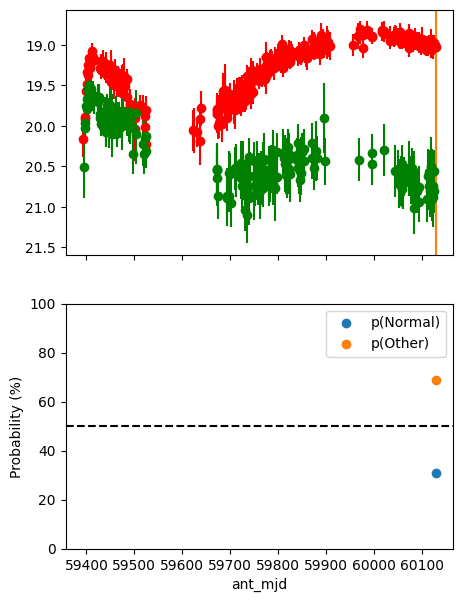

Span has already been finished; will not be reported again.


GHOST database already exists in the install path!
##############
Processing https://alerce.online/object/ZTF23aaejwfe
alerce_cls SNIa
Finding northern sources with Pan-starrs...
Found matches for 100.0% of events.
http://ps1images.stsci.edu/cgi-bin/ps1cutouts?pos=242.87702741+52.46274091&filter=color
Some features are NaN for ZTF23aaejwfe. Skip!


Span has already been finished; will not be reported again.


GHOST database already exists in the install path!
##############
In galactic plane at b=13.451553443027969. Don't use. Skip!


Span has already been finished; will not be reported again.


GHOST database already exists in the install path!
##############
Processing https://alerce.online/object/ZTF21aasbcjn
alerce_cls Blazar
Alerce class=Blazar is not SN ('SLSN', 'SN', 'SNII', 'SNIa', 'SNIbc') for ZTF21aasbcjn. Skip!


Span has already been finished; will not be reported again.


GHOST database already exists in the install path!
##############
Processing https://alerce.online/object/ZTF23aaekebt
alerce_cls SNII
Finding northern sources with Pan-starrs...
Found matches for 100.0% of events.
http://ps1images.stsci.edu/cgi-bin/ps1cutouts?pos=270.85806339+21.15141586&filter=color
ZTF23aaekebt is NOT anomalous according to RFC model (anom score=44.0%). Skip!


[Parallel(n_jobs=40)]: Using backend ThreadingBackend with 40 concurrent workers.
[Parallel(n_jobs=40)]: Done 100 out of 100 | elapsed:    0.0s finished
Span has already been finished; will not be reported again.


GHOST database already exists in the install path!
2023-07-04 08:45:04,900 - WARNING MainThread cassandra.py:list_by_location:1187 - Catalog object not found (catalog_id=19, object_id=959574397)
##############
In galactic plane at b=10.068984140497271. Don't use. Skip!


Span has already been finished; will not be reported again.


GHOST database already exists in the install path!
2023-07-04 08:45:07,439 - WARNING MainThread cassandra.py:list_by_location:1187 - Catalog object not found (catalog_id=19, object_id=344360732)
##############
In galactic plane at b=-12.028927900188883. Don't use. Skip!


Span has already been finished; will not be reported again.


GHOST database already exists in the install path!
2023-07-04 08:45:09,420 - WARNING MainThread cassandra.py:list_by_location:1187 - Catalog object not found (catalog_id=19, object_id=444722407)
##############
In galactic plane at b=-10.516074530039566. Don't use. Skip!


Span has already been finished; will not be reported again.


GHOST database already exists in the install path!
2023-07-04 08:45:11,730 - WARNING MainThread cassandra.py:list_by_location:1187 - Catalog object not found (catalog_id=19, object_id=437427715)
##############
In galactic plane at b=-10.12234993904309. Don't use. Skip!


Span has already been finished; will not be reported again.


GHOST database already exists in the install path!
##############
In galactic plane at b=-13.187797461631904. Don't use. Skip!


Span has already been finished; will not be reported again.


GHOST database already exists in the install path!
2023-07-04 08:45:16,150 - WARNING MainThread cassandra.py:list_by_location:1187 - Catalog object not found (catalog_id=19, object_id=771508875)
##############
In galactic plane at b=14.301459687983611. Don't use. Skip!


Span has already been finished; will not be reported again.


GHOST database already exists in the install path!
##############
Processing https://alerce.online/object/ZTF18adixhgm
alerce_cls VS
Alerce class=VS is not SN ('SLSN', 'SN', 'SNII', 'SNIa', 'SNIbc') for ZTF18adixhgm. Skip!


Span has already been finished; will not be reported again.


GHOST database already exists in the install path!
##############
Processing https://alerce.online/object/ZTF18adqjwlg
alerce_cls QSO
Alerce class=QSO is not SN ('SLSN', 'SN', 'SNII', 'SNIa', 'SNIbc') for ZTF18adqjwlg. Skip!


Span has already been finished; will not be reported again.


GHOST database already exists in the install path!
##############
Processing https://alerce.online/object/ZTF23aafwtbq
alerce_cls SNIa
Finding northern sources with Pan-starrs...
Found matches for 100.0% of events.
http://ps1images.stsci.edu/cgi-bin/ps1cutouts?pos=277.92965137+77.7597334&filter=color
ZTF23aafwtbq is NOT anomalous according to RFC model (anom score=18.0%). Skip!


[Parallel(n_jobs=40)]: Using backend ThreadingBackend with 40 concurrent workers.
[Parallel(n_jobs=40)]: Done 100 out of 100 | elapsed:    0.0s finished
Span has already been finished; will not be reported again.


GHOST database already exists in the install path!
##############
Processing https://alerce.online/object/ZTF23aahfxpr
alerce_cls SNIa
Finding northern sources with Pan-starrs...
Found matches for 100.0% of events.
http://ps1images.stsci.edu/cgi-bin/ps1cutouts?pos=231.24954742+68.75579722&filter=color
Some features are NaN for ZTF23aahfxpr. Skip!


Span has already been finished; will not be reported again.


GHOST database already exists in the install path!
##############
Processing https://alerce.online/object/ZTF18aarfwbx
alerce_cls Periodic-Other
Alerce class=Periodic-Other is not SN ('SLSN', 'SN', 'SNII', 'SNIa', 'SNIbc') for ZTF18aarfwbx. Skip!


Span has already been finished; will not be reported again.


GHOST database already exists in the install path!
##############
Processing https://alerce.online/object/ZTF18aaiufkw
alerce_cls CV/Nova
Alerce class=CV/Nova is not SN ('SLSN', 'SN', 'SNII', 'SNIa', 'SNIbc') for ZTF18aaiufkw. Skip!
CPU times: user 39.4 s, sys: 2.11 s, total: 41.5 s
Wall time: 1min 50s


In [14]:
%%time

for loc in locus_ids[50:75]:
    report = dk.run_filter(LAISS_RFC_AD_filter, locus=loc)

In [15]:
%%time

for loc in locus_ids[75:100]:
    report = dk.run_filter(LAISS_RFC_AD_filter, locus=loc)

Span has already been finished; will not be reported again.


GHOST database already exists in the install path!
##############
Processing https://alerce.online/object/ZTF22aaausxq
alerce_cls QSO
Alerce class=QSO is not SN ('SLSN', 'SN', 'SNII', 'SNIa', 'SNIbc') for ZTF22aaausxq. Skip!


Span has already been finished; will not be reported again.


GHOST database already exists in the install path!
##############
Processing https://alerce.online/object/ZTF18aajatec
alerce_cls QSO
Alerce class=QSO is not SN ('SLSN', 'SN', 'SNII', 'SNIa', 'SNIbc') for ZTF18aajatec. Skip!


Span has already been finished; will not be reported again.


GHOST database already exists in the install path!
##############
Processing https://alerce.online/object/ZTF23aahnmag
alerce_cls SLSN
Finding northern sources with Pan-starrs...
Found matches for 100.0% of events.
http://ps1images.stsci.edu/cgi-bin/ps1cutouts?pos=238.7534058+39.6697419&filter=color
ZTF23aahnmag is NOT anomalous according to RFC model (anom score=48.0%). Skip!


[Parallel(n_jobs=40)]: Using backend ThreadingBackend with 40 concurrent workers.
[Parallel(n_jobs=40)]: Done 100 out of 100 | elapsed:    0.0s finished
Span has already been finished; will not be reported again.


GHOST database already exists in the install path!
2023-07-04 08:46:04,373 - WARNING MainThread cassandra.py:list_by_location:1187 - Catalog object not found (catalog_id=19, object_id=931748531)
##############
Processing https://alerce.online/object/ZTF21aazjruy
alerce_cls QSO
Alerce class=QSO is not SN ('SLSN', 'SN', 'SNII', 'SNIa', 'SNIbc') for ZTF21aazjruy. Skip!


Span has already been finished; will not be reported again.


GHOST database already exists in the install path!
2023-07-04 08:46:07,885 - WARNING MainThread cassandra.py:list_by_location:1187 - Catalog object not found (catalog_id=19, object_id=684584918)
##############
Processing https://alerce.online/object/ZTF18aavskkv
alerce_cls RRL
Alerce class=RRL is not SN ('SLSN', 'SN', 'SNII', 'SNIa', 'SNIbc') for ZTF18aavskkv. Skip!


Span has already been finished; will not be reported again.


GHOST database already exists in the install path!
2023-07-04 08:46:11,050 - WARNING MainThread cassandra.py:list_by_location:1187 - Catalog object not found (catalog_id=19, object_id=668276055)
##############
Processing https://alerce.online/object/ZTF18aaqnqvg
alerce_cls RRL
Alerce class=RRL is not SN ('SLSN', 'SN', 'SNII', 'SNIa', 'SNIbc') for ZTF18aaqnqvg. Skip!


Span has already been finished; will not be reported again.


GHOST database already exists in the install path!
2023-07-04 08:46:14,240 - WARNING MainThread cassandra.py:list_by_location:1187 - Catalog object not found (catalog_id=19, object_id=591885562)
##############
Processing https://alerce.online/object/ZTF18abcpokm
alerce_cls RRL
Alerce class=RRL is not SN ('SLSN', 'SN', 'SNII', 'SNIa', 'SNIbc') for ZTF18abcpokm. Skip!


Span has already been finished; will not be reported again.


GHOST database already exists in the install path!
2023-07-04 08:46:17,676 - WARNING MainThread cassandra.py:list_by_location:1187 - Catalog object not found (catalog_id=19, object_id=366459067)
##############
Processing https://alerce.online/object/ZTF18abedgrj
alerce_cls E
Alerce class=E is not SN ('SLSN', 'SN', 'SNII', 'SNIa', 'SNIbc') for ZTF18abedgrj. Skip!


Span has already been finished; will not be reported again.


GHOST database already exists in the install path!
2023-07-04 08:46:20,492 - WARNING MainThread cassandra.py:list_by_location:1187 - Catalog object not found (catalog_id=19, object_id=511301158)
##############
Processing https://alerce.online/object/ZTF21aazrvcr
alerce_cls QSO
Alerce class=QSO is not SN ('SLSN', 'SN', 'SNII', 'SNIa', 'SNIbc') for ZTF21aazrvcr. Skip!


Span has already been finished; will not be reported again.


GHOST database already exists in the install path!
2023-07-04 08:46:22,449 - WARNING MainThread cassandra.py:list_by_location:1187 - Catalog object not found (catalog_id=19, object_id=501216546)
##############
Processing https://alerce.online/object/ZTF19acekpoy
alerce_cls CV/Nova
Alerce class=CV/Nova is not SN ('SLSN', 'SN', 'SNII', 'SNIa', 'SNIbc') for ZTF19acekpoy. Skip!


Span has already been finished; will not be reported again.


GHOST database already exists in the install path!
2023-07-04 08:46:26,271 - WARNING MainThread cassandra.py:list_by_location:1187 - Catalog object not found (catalog_id=19, object_id=592029677)
##############
Processing https://alerce.online/object/ZTF18ablrmqo
alerce_cls RRL
Alerce class=RRL is not SN ('SLSN', 'SN', 'SNII', 'SNIa', 'SNIbc') for ZTF18ablrmqo. Skip!


Span has already been finished; will not be reported again.


GHOST database already exists in the install path!
2023-07-04 08:46:30,089 - WARNING MainThread cassandra.py:list_by_location:1187 - Catalog object not found (catalog_id=19, object_id=598963612)
##############
Processing https://alerce.online/object/ZTF18adlzzsh
alerce_cls CV/Nova
Alerce class=CV/Nova is not SN ('SLSN', 'SN', 'SNII', 'SNIa', 'SNIbc') for ZTF18adlzzsh. Skip!


Span has already been finished; will not be reported again.


GHOST database already exists in the install path!
2023-07-04 08:46:33,378 - WARNING MainThread cassandra.py:list_by_location:1187 - Catalog object not found (catalog_id=19, object_id=496726798)
##############
Processing https://alerce.online/object/ZTF19aaafqao
alerce_cls CV/Nova
Alerce class=CV/Nova is not SN ('SLSN', 'SN', 'SNII', 'SNIa', 'SNIbc') for ZTF19aaafqao. Skip!


Span has already been finished; will not be reported again.


GHOST database already exists in the install path!
##############
In galactic plane at b=14.15395911281555. Don't use. Skip!


Span has already been finished; will not be reported again.


GHOST database already exists in the install path!
2023-07-04 08:46:38,812 - WARNING MainThread cassandra.py:list_by_location:1187 - Catalog object not found (catalog_id=19, object_id=217220170)
##############
In galactic plane at b=10.607189237448482. Don't use. Skip!


Span has already been finished; will not be reported again.


GHOST database already exists in the install path!
##############
In galactic plane at b=10.487832175269142. Don't use. Skip!


Span has already been finished; will not be reported again.


GHOST database already exists in the install path!
2023-07-04 08:46:44,449 - WARNING MainThread cassandra.py:list_by_location:1187 - Catalog object not found (catalog_id=19, object_id=193690614)
##############
In galactic plane at b=11.800392331897362. Don't use. Skip!


Span has already been finished; will not be reported again.


GHOST database already exists in the install path!
2023-07-04 08:46:47,392 - WARNING MainThread cassandra.py:list_by_location:1187 - Catalog object not found (catalog_id=19, object_id=349542991)
##############
In galactic plane at b=13.013438557457754. Don't use. Skip!


Span has already been finished; will not be reported again.


GHOST database already exists in the install path!
##############
Processing https://alerce.online/object/ZTF21aazywsl
alerce_cls Blazar
Alerce class=Blazar is not SN ('SLSN', 'SN', 'SNII', 'SNIa', 'SNIbc') for ZTF21aazywsl. Skip!


Span has already been finished; will not be reported again.


GHOST database already exists in the install path!
2023-07-04 08:46:52,947 - WARNING MainThread cassandra.py:list_by_location:1187 - Catalog object not found (catalog_id=19, object_id=749525667)
##############
Processing https://alerce.online/object/ZTF21acdowtu
alerce_cls AGN
Alerce class=AGN is not SN ('SLSN', 'SN', 'SNII', 'SNIa', 'SNIbc') for ZTF21acdowtu. Skip!


Span has already been finished; will not be reported again.


GHOST database already exists in the install path!
2023-07-04 08:46:55,251 - WARNING MainThread cassandra.py:list_by_location:1187 - Catalog object not found (catalog_id=19, object_id=824798858)
##############
Processing https://alerce.online/object/ZTF22aanwibf
alerce_cls SLSN
Finding northern sources with Pan-starrs...
Found matches for 100.0% of events.
http://ps1images.stsci.edu/cgi-bin/ps1cutouts?pos=219.75813572+15.98978812&filter=color
ZTF22aanwibf is NOT anomalous according to RFC model (anom score=30.0%). Skip!


[Parallel(n_jobs=40)]: Using backend ThreadingBackend with 40 concurrent workers.
[Parallel(n_jobs=40)]: Done 100 out of 100 | elapsed:    0.0s finished
Span has already been finished; will not be reported again.


GHOST database already exists in the install path!
2023-07-04 08:47:05,106 - WARNING MainThread cassandra.py:list_by_location:1187 - Catalog object not found (catalog_id=19, object_id=104464337)
##############
Processing https://alerce.online/object/ZTF19aaxligy
alerce_cls YSO
Alerce class=YSO is not SN ('SLSN', 'SN', 'SNII', 'SNIa', 'SNIbc') for ZTF19aaxligy. Skip!


Span has already been finished; will not be reported again.


GHOST database already exists in the install path!
##############
Processing https://alerce.online/object/ZTF19aaxlnbk
alerce_cls RRL
Alerce class=RRL is not SN ('SLSN', 'SN', 'SNII', 'SNIa', 'SNIbc') for ZTF19aaxlnbk. Skip!


Span has already been finished; will not be reported again.


GHOST database already exists in the install path!
##############
Processing https://alerce.online/object/ZTF19aayyedn
alerce_cls RRL
Alerce class=RRL is not SN ('SLSN', 'SN', 'SNII', 'SNIa', 'SNIbc') for ZTF19aayyedn. Skip!


Span has already been finished; will not be reported again.


GHOST database already exists in the install path!
2023-07-04 08:47:18,130 - WARNING MainThread cassandra.py:list_by_location:1187 - Catalog object not found (catalog_id=19, object_id=198340902)
##############
Processing https://alerce.online/object/ZTF21aazruji
alerce_cls Periodic-Other
Alerce class=Periodic-Other is not SN ('SLSN', 'SN', 'SNII', 'SNIa', 'SNIbc') for ZTF21aazruji. Skip!
CPU times: user 27.8 s, sys: 886 ms, total: 28.7 s
Wall time: 1min 37s


In [16]:
%%time

for loc in locus_ids[100:125]:
    report = dk.run_filter(LAISS_RFC_AD_filter, locus=loc)

Span has already been finished; will not be reported again.


GHOST database already exists in the install path!
##############
Processing https://alerce.online/object/ZTF23aafpygk
alerce_cls CV/Nova
Alerce class=CV/Nova is not SN ('SLSN', 'SN', 'SNII', 'SNIa', 'SNIbc') for ZTF23aafpygk. Skip!


Span has already been finished; will not be reported again.


GHOST database already exists in the install path!
##############
Processing https://alerce.online/object/ZTF18aakggiv
alerce_cls RRL
Alerce class=RRL is not SN ('SLSN', 'SN', 'SNII', 'SNIa', 'SNIbc') for ZTF18aakggiv. Skip!


Span has already been finished; will not be reported again.


GHOST database already exists in the install path!
##############
Processing https://alerce.online/object/ZTF18aagrtrn
Error getting best alerce classifier result for ZTF18aagrtrn. Skip!


Span has already been finished; will not be reported again.


GHOST database already exists in the install path!
##############
Processing https://alerce.online/object/ZTF18aajljgf
alerce_cls DSCT
Alerce class=DSCT is not SN ('SLSN', 'SN', 'SNII', 'SNIa', 'SNIbc') for ZTF18aajljgf. Skip!


Span has already been finished; will not be reported again.


GHOST database already exists in the install path!
##############
Processing https://alerce.online/object/ZTF18aaaaalp
alerce_cls RRL
Alerce class=RRL is not SN ('SLSN', 'SN', 'SNII', 'SNIa', 'SNIbc') for ZTF18aaaaalp. Skip!


Span has already been finished; will not be reported again.


GHOST database already exists in the install path!
##############
Processing https://alerce.online/object/ZTF18aagrhwr
alerce_cls RRL
Alerce class=RRL is not SN ('SLSN', 'SN', 'SNII', 'SNIa', 'SNIbc') for ZTF18aagrhwr. Skip!


Span has already been finished; will not be reported again.


GHOST database already exists in the install path!
2023-07-04 08:58:37,880 - WARNING MainThread cassandra.py:list_by_location:1187 - Catalog object not found (catalog_id=19, object_id=819910432)
##############
Processing https://alerce.online/object/ZTF18abdfgzc
alerce_cls RRL
Alerce class=RRL is not SN ('SLSN', 'SN', 'SNII', 'SNIa', 'SNIbc') for ZTF18abdfgzc. Skip!


Span has already been finished; will not be reported again.


GHOST database already exists in the install path!
2023-07-04 08:58:40,437 - WARNING MainThread cassandra.py:list_by_location:1187 - Catalog object not found (catalog_id=19, object_id=335682340)
##############
Processing https://alerce.online/object/ZTF18adbagop
alerce_cls Periodic-Other
Alerce class=Periodic-Other is not SN ('SLSN', 'SN', 'SNII', 'SNIa', 'SNIbc') for ZTF18adbagop. Skip!


Span has already been finished; will not be reported again.


GHOST database already exists in the install path!
2023-07-04 08:58:42,797 - WARNING MainThread cassandra.py:list_by_location:1187 - Catalog object not found (catalog_id=19, object_id=366767592)
##############
Processing https://alerce.online/object/ZTF19aapwcjj
alerce_cls Periodic-Other
Alerce class=Periodic-Other is not SN ('SLSN', 'SN', 'SNII', 'SNIa', 'SNIbc') for ZTF19aapwcjj. Skip!


Span has already been finished; will not be reported again.


GHOST database already exists in the install path!
2023-07-04 08:58:55,299 - WARNING MainThread cassandra.py:list_by_location:1187 - Catalog object not found (catalog_id=19, object_id=339656795)
##############
Processing https://alerce.online/object/ZTF18adbafbx
alerce_cls RRL
Alerce class=RRL is not SN ('SLSN', 'SN', 'SNII', 'SNIa', 'SNIbc') for ZTF18adbafbx. Skip!


Span has already been finished; will not be reported again.


GHOST database already exists in the install path!
2023-07-04 08:58:58,464 - WARNING MainThread cassandra.py:list_by_location:1187 - Catalog object not found (catalog_id=19, object_id=800249103)
##############
Processing https://alerce.online/object/ZTF18abetddu
alerce_cls RRL
Alerce class=RRL is not SN ('SLSN', 'SN', 'SNII', 'SNIa', 'SNIbc') for ZTF18abetddu. Skip!


Span has already been finished; will not be reported again.


GHOST database already exists in the install path!
2023-07-04 08:59:01,079 - WARNING MainThread cassandra.py:list_by_location:1187 - Catalog object not found (catalog_id=19, object_id=427587360)
##############
Processing https://alerce.online/object/ZTF19aadoqnh
alerce_cls E
Alerce class=E is not SN ('SLSN', 'SN', 'SNII', 'SNIa', 'SNIbc') for ZTF19aadoqnh. Skip!


Span has already been finished; will not be reported again.


GHOST database already exists in the install path!
2023-07-04 08:59:03,920 - WARNING MainThread cassandra.py:list_by_location:1187 - Catalog object not found (catalog_id=19, object_id=271045461)
##############
In galactic plane at b=14.090780358779652. Don't use. Skip!


Span has already been finished; will not be reported again.


GHOST database already exists in the install path!
2023-07-04 08:59:06,983 - WARNING MainThread cassandra.py:list_by_location:1187 - Catalog object not found (catalog_id=19, object_id=263846113)
##############
In galactic plane at b=12.083092112006137. Don't use. Skip!


Span has already been finished; will not be reported again.


GHOST database already exists in the install path!
2023-07-04 08:59:09,959 - WARNING MainThread cassandra.py:list_by_location:1187 - Catalog object not found (catalog_id=19, object_id=199037789)
##############
In galactic plane at b=11.126108446635236. Don't use. Skip!


Span has already been finished; will not be reported again.


GHOST database already exists in the install path!
2023-07-04 08:59:13,008 - WARNING MainThread cassandra.py:list_by_location:1187 - Catalog object not found (catalog_id=19, object_id=194378281)
##############
In galactic plane at b=13.874114681859513. Don't use. Skip!


Span has already been finished; will not be reported again.


GHOST database already exists in the install path!
##############
In galactic plane at b=13.160743469838206. Don't use. Skip!


Span has already been finished; will not be reported again.


GHOST database already exists in the install path!
2023-07-04 08:59:18,235 - WARNING MainThread cassandra.py:list_by_location:1187 - Catalog object not found (catalog_id=19, object_id=66118783)
##############
In galactic plane at b=10.201170546016964. Don't use. Skip!


Span has already been finished; will not be reported again.


GHOST database already exists in the install path!
2023-07-04 08:59:20,830 - WARNING MainThread cassandra.py:list_by_location:1187 - Catalog object not found (catalog_id=19, object_id=91697292)
##############
In galactic plane at b=11.136233536407751. Don't use. Skip!


Span has already been finished; will not be reported again.


GHOST database already exists in the install path!
##############
Processing https://alerce.online/object/ZTF18adqwkdt
alerce_cls bogus
Alerce class=bogus is not SN ('SLSN', 'SN', 'SNII', 'SNIa', 'SNIbc') for ZTF18adqwkdt. Skip!


Span has already been finished; will not be reported again.


GHOST database already exists in the install path!
##############
Processing https://alerce.online/object/ZTF22aagdxmo
alerce_cls QSO
Alerce class=QSO is not SN ('SLSN', 'SN', 'SNII', 'SNIa', 'SNIbc') for ZTF22aagdxmo. Skip!


Span has already been finished; will not be reported again.


GHOST database already exists in the install path!
##############
Processing https://alerce.online/object/ZTF22abvmgtl
alerce_cls SNII
Finding northern sources with Pan-starrs...
Found matches for 100.0% of events.
http://ps1images.stsci.edu/cgi-bin/ps1cutouts?pos=216.42112539+57.94721967&filter=color
Some features are NaN for ZTF22abvmgtl. Skip!


Span has already been finished; will not be reported again.


GHOST database already exists in the install path!
##############
Processing https://alerce.online/object/ZTF19aauynhv
alerce_cls LPV
Alerce class=LPV is not SN ('SLSN', 'SN', 'SNII', 'SNIa', 'SNIbc') for ZTF19aauynhv. Skip!


Span has already been finished; will not be reported again.


GHOST database already exists in the install path!
2023-07-04 08:59:39,042 - WARNING MainThread cassandra.py:list_by_location:1187 - Catalog object not found (catalog_id=19, object_id=87309832)
##############
Processing https://alerce.online/object/ZTF19aauynbg
alerce_cls CEP
Alerce class=CEP is not SN ('SLSN', 'SN', 'SNII', 'SNIa', 'SNIbc') for ZTF19aauynbg. Skip!


Span has already been finished; will not be reported again.


GHOST database already exists in the install path!
2023-07-04 08:59:52,615 - WARNING MainThread cassandra.py:list_by_location:1187 - Catalog object not found (catalog_id=19, object_id=961972270)
##############
Processing https://alerce.online/object/ZTF21abgzhrd
alerce_cls QSO
Alerce class=QSO is not SN ('SLSN', 'SN', 'SNII', 'SNIa', 'SNIbc') for ZTF21abgzhrd. Skip!
CPU times: user 21.1 s, sys: 665 ms, total: 21.8 s
Wall time: 1min 34s


In [17]:
%%time

for loc in locus_ids[125:150]:
    report = dk.run_filter(LAISS_RFC_AD_filter, locus=loc)

Span has already been finished; will not be reported again.


GHOST database already exists in the install path!
2023-07-04 08:59:55,122 - WARNING MainThread cassandra.py:list_by_location:1187 - Catalog object not found (catalog_id=19, object_id=667036453)
##############
Processing https://alerce.online/object/ZTF21abfxjdk
alerce_cls AGN
Alerce class=AGN is not SN ('SLSN', 'SN', 'SNII', 'SNIa', 'SNIbc') for ZTF21abfxjdk. Skip!


Span has already been finished; will not be reported again.


GHOST database already exists in the install path!
2023-07-04 08:59:57,893 - WARNING MainThread cassandra.py:list_by_location:1187 - Catalog object not found (catalog_id=19, object_id=343424406)
##############
Processing https://alerce.online/object/ZTF18abuvcue
alerce_cls E
Alerce class=E is not SN ('SLSN', 'SN', 'SNII', 'SNIa', 'SNIbc') for ZTF18abuvcue. Skip!


Span has already been finished; will not be reported again.


GHOST database already exists in the install path!
2023-07-04 09:00:00,758 - WARNING MainThread cassandra.py:list_by_location:1187 - Catalog object not found (catalog_id=19, object_id=850040064)
##############
Processing https://alerce.online/object/ZTF17aaaegrd
alerce_cls RRL
Alerce class=RRL is not SN ('SLSN', 'SN', 'SNII', 'SNIa', 'SNIbc') for ZTF17aaaegrd. Skip!


Span has already been finished; will not be reported again.


GHOST database already exists in the install path!
##############
Processing https://alerce.online/object/ZTF18abxmbfq
alerce_cls CV/Nova
Alerce class=CV/Nova is not SN ('SLSN', 'SN', 'SNII', 'SNIa', 'SNIbc') for ZTF18abxmbfq. Skip!


Span has already been finished; will not be reported again.


GHOST database already exists in the install path!
##############
Processing https://alerce.online/object/ZTF18admgsrz
alerce_cls E
Alerce class=E is not SN ('SLSN', 'SN', 'SNII', 'SNIa', 'SNIbc') for ZTF18admgsrz. Skip!


Span has already been finished; will not be reported again.


GHOST database already exists in the install path!
##############
In galactic plane at b=-10.285091546538617. Don't use. Skip!


Span has already been finished; will not be reported again.


GHOST database already exists in the install path!
##############
In galactic plane at b=12.510085554738627. Don't use. Skip!


Span has already been finished; will not be reported again.


GHOST database already exists in the install path!
##############
In galactic plane at b=10.925776913679254. Don't use. Skip!


Span has already been finished; will not be reported again.


GHOST database already exists in the install path!
##############
In galactic plane at b=-11.284401112419333. Don't use. Skip!


Span has already been finished; will not be reported again.


GHOST database already exists in the install path!
2023-07-04 09:00:29,605 - WARNING MainThread cassandra.py:list_by_location:1187 - Catalog object not found (catalog_id=19, object_id=567318317)
##############
Processing https://alerce.online/object/ZTF22aaijqzb
alerce_cls QSO
Alerce class=QSO is not SN ('SLSN', 'SN', 'SNII', 'SNIa', 'SNIbc') for ZTF22aaijqzb. Skip!


Span has already been finished; will not be reported again.


GHOST database already exists in the install path!
2023-07-04 09:00:32,079 - WARNING MainThread cassandra.py:list_by_location:1187 - Catalog object not found (catalog_id=19, object_id=493523741)
##############
Processing https://alerce.online/object/ZTF20acafykp
alerce_cls Periodic-Other
Alerce class=Periodic-Other is not SN ('SLSN', 'SN', 'SNII', 'SNIa', 'SNIbc') for ZTF20acafykp. Skip!


Span has already been finished; will not be reported again.


GHOST database already exists in the install path!
##############
Processing https://alerce.online/object/ZTF18absuttp
alerce_cls E
Alerce class=E is not SN ('SLSN', 'SN', 'SNII', 'SNIa', 'SNIbc') for ZTF18absuttp. Skip!


Span has already been finished; will not be reported again.


GHOST database already exists in the install path!
2023-07-04 09:00:40,370 - WARNING MainThread cassandra.py:list_by_location:1187 - Catalog object not found (catalog_id=19, object_id=965757455)
##############
Processing https://alerce.online/object/ZTF22aallblq
alerce_cls QSO
Alerce class=QSO is not SN ('SLSN', 'SN', 'SNII', 'SNIa', 'SNIbc') for ZTF22aallblq. Skip!


Span has already been finished; will not be reported again.


GHOST database already exists in the install path!
##############
Processing https://alerce.online/object/ZTF22aarxwcb
alerce_cls VS
Alerce class=VS is not SN ('SLSN', 'SN', 'SNII', 'SNIa', 'SNIbc') for ZTF22aarxwcb. Skip!


Span has already been finished; will not be reported again.


GHOST database already exists in the install path!
##############
Processing https://alerce.online/object/ZTF22aajbpni
alerce_cls QSO
Alerce class=QSO is not SN ('SLSN', 'SN', 'SNII', 'SNIa', 'SNIbc') for ZTF22aajbpni. Skip!


Span has already been finished; will not be reported again.


GHOST database already exists in the install path!
##############
Processing https://alerce.online/object/ZTF20acxazal
alerce_cls QSO
Alerce class=QSO is not SN ('SLSN', 'SN', 'SNII', 'SNIa', 'SNIbc') for ZTF20acxazal. Skip!


Span has already been finished; will not be reported again.


GHOST database already exists in the install path!
##############
In galactic plane at b=-13.992340706325338. Don't use. Skip!


Span has already been finished; will not be reported again.


GHOST database already exists in the install path!
##############
Processing https://alerce.online/object/ZTF21abfqkfs
alerce_cls QSO
Alerce class=QSO is not SN ('SLSN', 'SN', 'SNII', 'SNIa', 'SNIbc') for ZTF21abfqkfs. Skip!


Span has already been finished; will not be reported again.


GHOST database already exists in the install path!
2023-07-04 09:01:02,684 - WARNING MainThread cassandra.py:list_by_location:1187 - Catalog object not found (catalog_id=19, object_id=781041674)
##############
In galactic plane at b=-10.541674514390241. Don't use. Skip!


Span has already been finished; will not be reported again.


GHOST database already exists in the install path!
2023-07-04 09:01:05,149 - WARNING MainThread cassandra.py:list_by_location:1187 - Catalog object not found (catalog_id=19, object_id=704596015)
##############
In galactic plane at b=-12.625178713283324. Don't use. Skip!


Span has already been finished; will not be reported again.


GHOST database already exists in the install path!
2023-07-04 09:01:08,443 - WARNING MainThread cassandra.py:list_by_location:1187 - Catalog object not found (catalog_id=19, object_id=976332082)
2023-07-04 09:01:08,444 - WARNING MainThread cassandra.py:list_by_location:1187 - Catalog object not found (catalog_id=19, object_id=976332083)
##############
In galactic plane at b=-12.479768007076856. Don't use. Skip!


Span has already been finished; will not be reported again.


GHOST database already exists in the install path!
2023-07-04 09:01:11,648 - WARNING MainThread cassandra.py:list_by_location:1187 - Catalog object not found (catalog_id=19, object_id=815471099)
##############
Processing https://alerce.online/object/ZTF18aazmwtv
alerce_cls RRL
Alerce class=RRL is not SN ('SLSN', 'SN', 'SNII', 'SNIa', 'SNIbc') for ZTF18aazmwtv. Skip!


Span has already been finished; will not be reported again.


GHOST database already exists in the install path!
##############
Processing https://alerce.online/object/ZTF23aaekiqe
alerce_cls SNIbc
Finding northern sources with Pan-starrs...
Found matches for 100.0% of events.
http://ps1images.stsci.edu/cgi-bin/ps1cutouts?pos=306.16073496+6.63188821&filter=color
Some features are NaN for ZTF23aaekiqe. Skip!


Span has already been finished; will not be reported again.


GHOST database already exists in the install path!
2023-07-04 09:01:23,910 - WARNING MainThread cassandra.py:list_by_location:1187 - Catalog object not found (catalog_id=19, object_id=450197388)
##############
Processing https://alerce.online/object/ZTF18abmqumy
alerce_cls E
Alerce class=E is not SN ('SLSN', 'SN', 'SNII', 'SNIa', 'SNIbc') for ZTF18abmqumy. Skip!


Span has already been finished; will not be reported again.


GHOST database already exists in the install path!
2023-07-04 09:01:26,821 - WARNING MainThread cassandra.py:list_by_location:1187 - Catalog object not found (catalog_id=19, object_id=417790765)
##############
Processing https://alerce.online/object/ZTF18abobpku
alerce_cls RRL
Alerce class=RRL is not SN ('SLSN', 'SN', 'SNII', 'SNIa', 'SNIbc') for ZTF18abobpku. Skip!
CPU times: user 22.1 s, sys: 646 ms, total: 22.7 s
Wall time: 1min 34s


In [18]:
%%time

for loc in locus_ids[150:175]:
    report = dk.run_filter(LAISS_RFC_AD_filter, locus=loc)

Span has already been finished; will not be reported again.


GHOST database already exists in the install path!
2023-07-04 09:01:29,544 - WARNING MainThread cassandra.py:list_by_location:1187 - Catalog object not found (catalog_id=19, object_id=182861756)
##############
In galactic plane at b=-14.46528457012404. Don't use. Skip!


Span has already been finished; will not be reported again.


GHOST database already exists in the install path!
##############
In galactic plane at b=-14.528304104662743. Don't use. Skip!


Span has already been finished; will not be reported again.


GHOST database already exists in the install path!
##############
Processing https://alerce.online/object/ZTF18abdlfnj
alerce_cls LPV
Alerce class=LPV is not SN ('SLSN', 'SN', 'SNII', 'SNIa', 'SNIbc') for ZTF18abdlfnj. Skip!


Span has already been finished; will not be reported again.


GHOST database already exists in the install path!
2023-07-04 09:01:37,727 - WARNING MainThread cassandra.py:list_by_location:1187 - Catalog object not found (catalog_id=19, object_id=188248513)
##############
Processing https://alerce.online/object/ZTF19adddktb
alerce_cls LPV
Alerce class=LPV is not SN ('SLSN', 'SN', 'SNII', 'SNIa', 'SNIbc') for ZTF19adddktb. Skip!


Span has already been finished; will not be reported again.


GHOST database already exists in the install path!
##############
Processing https://alerce.online/object/ZTF19aayhtfx
alerce_cls LPV
Alerce class=LPV is not SN ('SLSN', 'SN', 'SNII', 'SNIa', 'SNIbc') for ZTF19aayhtfx. Skip!


Span has already been finished; will not be reported again.


GHOST database already exists in the install path!
##############
Processing https://alerce.online/object/ZTF19aawsbte
alerce_cls LPV
Alerce class=LPV is not SN ('SLSN', 'SN', 'SNII', 'SNIa', 'SNIbc') for ZTF19aawsbte. Skip!


Span has already been finished; will not be reported again.


GHOST database already exists in the install path!
2023-07-04 09:01:45,935 - WARNING MainThread cassandra.py:list_by_location:1187 - Catalog object not found (catalog_id=19, object_id=154283136)
##############
Processing https://alerce.online/object/ZTF19aayhseh
alerce_cls RRL
Alerce class=RRL is not SN ('SLSN', 'SN', 'SNII', 'SNIa', 'SNIbc') for ZTF19aayhseh. Skip!


Span has already been finished; will not be reported again.


GHOST database already exists in the install path!
2023-07-04 09:01:53,668 - WARNING MainThread cassandra.py:list_by_location:1187 - Catalog object not found (catalog_id=19, object_id=423440458)
##############
Processing https://alerce.online/object/ZTF22aapjskk
alerce_cls QSO
Alerce class=QSO is not SN ('SLSN', 'SN', 'SNII', 'SNIa', 'SNIbc') for ZTF22aapjskk. Skip!


Span has already been finished; will not be reported again.


GHOST database already exists in the install path!
2023-07-04 09:01:56,085 - WARNING MainThread cassandra.py:list_by_location:1187 - Catalog object not found (catalog_id=19, object_id=584165519)
##############
Processing https://alerce.online/object/ZTF22aanvqhn
alerce_cls SLSN
Finding northern sources with Pan-starrs...
Found matches for 100.0% of events.
http://ps1images.stsci.edu/cgi-bin/ps1cutouts?pos=344.74966873+0.54472805&filter=color
ZTF22aanvqhn is NOT anomalous according to RFC model (anom score=41.0%). Skip!


[Parallel(n_jobs=40)]: Using backend ThreadingBackend with 40 concurrent workers.
[Parallel(n_jobs=40)]: Done 100 out of 100 | elapsed:    0.0s finished
Span has already been finished; will not be reported again.


GHOST database already exists in the install path!
2023-07-04 09:02:05,112 - WARNING MainThread cassandra.py:list_by_location:1187 - Catalog object not found (catalog_id=19, object_id=935040322)
##############
Processing https://alerce.online/object/ZTF22aalwwww
alerce_cls QSO
Alerce class=QSO is not SN ('SLSN', 'SN', 'SNII', 'SNIa', 'SNIbc') for ZTF22aalwwww. Skip!


Span has already been finished; will not be reported again.


GHOST database already exists in the install path!
##############
Processing https://alerce.online/object/ZTF20abnfrlo
alerce_cls QSO
Alerce class=QSO is not SN ('SLSN', 'SN', 'SNII', 'SNIa', 'SNIbc') for ZTF20abnfrlo. Skip!


Span has already been finished; will not be reported again.


GHOST database already exists in the install path!
##############
Processing https://alerce.online/object/ZTF18abbnydk
alerce_cls E
Alerce class=E is not SN ('SLSN', 'SN', 'SNII', 'SNIa', 'SNIbc') for ZTF18abbnydk. Skip!


Span has already been finished; will not be reported again.


GHOST database already exists in the install path!
2023-07-04 09:02:18,566 - WARNING MainThread cassandra.py:list_by_location:1187 - Catalog object not found (catalog_id=19, object_id=654381287)
##############
Processing https://alerce.online/object/ZTF19abffrle
alerce_cls QSO
Alerce class=QSO is not SN ('SLSN', 'SN', 'SNII', 'SNIa', 'SNIbc') for ZTF19abffrle. Skip!


Span has already been finished; will not be reported again.


GHOST database already exists in the install path!
2023-07-04 09:02:20,844 - WARNING MainThread cassandra.py:list_by_location:1187 - Catalog object not found (catalog_id=19, object_id=384062244)
##############
Processing https://alerce.online/object/ZTF21abwxlnx
alerce_cls Periodic-Other
Alerce class=Periodic-Other is not SN ('SLSN', 'SN', 'SNII', 'SNIa', 'SNIbc') for ZTF21abwxlnx. Skip!


Span has already been finished; will not be reported again.


GHOST database already exists in the install path!
2023-07-04 09:02:23,579 - WARNING MainThread cassandra.py:list_by_location:1187 - Catalog object not found (catalog_id=19, object_id=981808996)
##############
In galactic plane at b=-14.002971238883113. Don't use. Skip!


Span has already been finished; will not be reported again.


GHOST database already exists in the install path!
2023-07-04 09:02:27,136 - WARNING MainThread cassandra.py:list_by_location:1187 - Catalog object not found (catalog_id=19, object_id=932617730)
2023-07-04 09:02:27,137 - WARNING MainThread cassandra.py:list_by_location:1187 - Catalog object not found (catalog_id=19, object_id=932617732)
##############
In galactic plane at b=-12.544774903373677. Don't use. Skip!


Span has already been finished; will not be reported again.


GHOST database already exists in the install path!
2023-07-04 09:02:30,253 - WARNING MainThread cassandra.py:list_by_location:1187 - Catalog object not found (catalog_id=19, object_id=586651225)
##############
Processing https://alerce.online/object/ZTF22aajfwnu
alerce_cls QSO
Alerce class=QSO is not SN ('SLSN', 'SN', 'SNII', 'SNIa', 'SNIbc') for ZTF22aajfwnu. Skip!


Span has already been finished; will not be reported again.


GHOST database already exists in the install path!
2023-07-04 09:02:32,696 - WARNING MainThread cassandra.py:list_by_location:1187 - Catalog object not found (catalog_id=19, object_id=505374784)
##############
Processing https://alerce.online/object/ZTF21aaxbguz
alerce_cls CV/Nova
Alerce class=CV/Nova is not SN ('SLSN', 'SN', 'SNII', 'SNIa', 'SNIbc') for ZTF21aaxbguz. Skip!


Span has already been finished; will not be reported again.


GHOST database already exists in the install path!
2023-07-04 09:02:35,411 - WARNING MainThread cassandra.py:list_by_location:1187 - Catalog object not found (catalog_id=19, object_id=170634960)
##############
In galactic plane at b=-13.612421785822933. Don't use. Skip!


Span has already been finished; will not be reported again.


GHOST database already exists in the install path!
2023-07-04 09:02:38,030 - WARNING MainThread cassandra.py:list_by_location:1187 - Catalog object not found (catalog_id=19, object_id=44476507)
##############
Processing https://alerce.online/object/ZTF18abbyovx
alerce_cls RRL
Alerce class=RRL is not SN ('SLSN', 'SN', 'SNII', 'SNIa', 'SNIbc') for ZTF18abbyovx. Skip!


Span has already been finished; will not be reported again.


GHOST database already exists in the install path!
2023-07-04 09:02:40,332 - WARNING MainThread cassandra.py:list_by_location:1187 - Catalog object not found (catalog_id=19, object_id=194987562)
##############
Processing https://alerce.online/object/ZTF18aboptcw
alerce_cls E
Alerce class=E is not SN ('SLSN', 'SN', 'SNII', 'SNIa', 'SNIbc') for ZTF18aboptcw. Skip!


Span has already been finished; will not be reported again.


GHOST database already exists in the install path!
2023-07-04 09:02:54,963 - WARNING MainThread cassandra.py:list_by_location:1187 - Catalog object not found (catalog_id=19, object_id=427058891)
##############
Processing https://alerce.online/object/ZTF18abtilug
alerce_cls E
Alerce class=E is not SN ('SLSN', 'SN', 'SNII', 'SNIa', 'SNIbc') for ZTF18abtilug. Skip!


Span has already been finished; will not be reported again.


GHOST database already exists in the install path!
2023-07-04 09:02:57,926 - WARNING MainThread cassandra.py:list_by_location:1187 - Catalog object not found (catalog_id=19, object_id=470454917)
##############
In galactic plane at b=-14.245745322099754. Don't use. Skip!


Span has already been finished; will not be reported again.


GHOST database already exists in the install path!
##############
In galactic plane at b=-11.231219579259667. Don't use. Skip!


Span has already been finished; will not be reported again.


GHOST database already exists in the install path!
2023-07-04 09:03:02,907 - WARNING MainThread cassandra.py:list_by_location:1187 - Catalog object not found (catalog_id=19, object_id=970719633)
##############
In galactic plane at b=13.914993043559921. Don't use. Skip!
CPU times: user 21.2 s, sys: 593 ms, total: 21.8 s
Wall time: 1min 35s


In [25]:
%%time

for loc in locus_ids[175:200]:
    report = dk.run_filter(LAISS_RFC_AD_filter, locus=loc)

Span has already been finished; will not be reported again.


GHOST database already exists in the install path!
##############
Processing https://alerce.online/object/ZTF21abcdurz
alerce_cls Periodic-Other
Alerce class=Periodic-Other is not SN ('SLSN', 'SN', 'SNII', 'SNIa', 'SNIbc') for ZTF21abcdurz. Skip!


Span has already been finished; will not be reported again.


GHOST database already exists in the install path!
##############
In galactic plane at b=14.642374865616894. Don't use. Skip!


Span has already been finished; will not be reported again.


GHOST database already exists in the install path!
##############
Processing https://alerce.online/object/ZTF23aaizygy
alerce_cls SNIa
1 transients not found in GHOST by name, trying a coordinate search...
1 transients not found in GHOST by name or coordinates, manually associating...
Found 1 hosts in GLADE! See gladeDLR.txt for details.
GHOST host association fails for ZTF23aaizygy. Skip!


Span has already been finished; will not be reported again.


GHOST database already exists in the install path!
##############
In galactic plane at b=14.47000194733687. Don't use. Skip!


Span has already been finished; will not be reported again.


GHOST database already exists in the install path!
##############
Processing https://alerce.online/object/ZTF21abaphim
alerce_cls QSO
Alerce class=QSO is not SN ('SLSN', 'SN', 'SNII', 'SNIa', 'SNIbc') for ZTF21abaphim. Skip!


Span has already been finished; will not be reported again.


GHOST database already exists in the install path!
##############
Processing https://alerce.online/object/ZTF18aagrimx
alerce_cls RRL
Alerce class=RRL is not SN ('SLSN', 'SN', 'SNII', 'SNIa', 'SNIbc') for ZTF18aagrimx. Skip!


Span has already been finished; will not be reported again.


GHOST database already exists in the install path!
##############
Processing https://alerce.online/object/ZTF18aammjth
alerce_cls RRL
Alerce class=RRL is not SN ('SLSN', 'SN', 'SNII', 'SNIa', 'SNIbc') for ZTF18aammjth. Skip!


Span has already been finished; will not be reported again.


GHOST database already exists in the install path!
##############
Processing https://alerce.online/object/ZTF18adivvst
alerce_cls E
Alerce class=E is not SN ('SLSN', 'SN', 'SNII', 'SNIa', 'SNIbc') for ZTF18adivvst. Skip!


Span has already been finished; will not be reported again.


GHOST database already exists in the install path!
##############
Processing https://alerce.online/object/ZTF21aaskxcz
alerce_cls QSO
Alerce class=QSO is not SN ('SLSN', 'SN', 'SNII', 'SNIa', 'SNIbc') for ZTF21aaskxcz. Skip!


Span has already been finished; will not be reported again.


GHOST database already exists in the install path!
##############
Processing https://alerce.online/object/ZTF23aalbnwv
alerce_cls QSO
Alerce class=QSO is not SN ('SLSN', 'SN', 'SNII', 'SNIa', 'SNIbc') for ZTF23aalbnwv. Skip!


Span has already been finished; will not be reported again.


GHOST database already exists in the install path!
##############
Processing https://alerce.online/object/ZTF20aapplju
alerce_cls QSO
Alerce class=QSO is not SN ('SLSN', 'SN', 'SNII', 'SNIa', 'SNIbc') for ZTF20aapplju. Skip!


Span has already been finished; will not be reported again.


GHOST database already exists in the install path!
##############
Processing https://alerce.online/object/ZTF18aapnlye
alerce_cls RRL
Alerce class=RRL is not SN ('SLSN', 'SN', 'SNII', 'SNIa', 'SNIbc') for ZTF18aapnlye. Skip!


Span has already been finished; will not be reported again.


GHOST database already exists in the install path!
##############
Processing https://alerce.online/object/ZTF22aapqaqe
alerce_cls SLSN
1 transients not found in GHOST by name, trying a coordinate search...
1 transients not found in GHOST by name or coordinates, manually associating...
Found 1 hosts in GLADE! See gladeDLR.txt for details.
GHOST host association fails for ZTF22aapqaqe. Skip!


Span has already been finished; will not be reported again.


GHOST database already exists in the install path!
##############
Processing https://alerce.online/object/ZTF23aaejumk
alerce_cls SNII
1 transients not found in GHOST by name, trying a coordinate search...
1 transients not found in GHOST by name or coordinates, manually associating...
Found 1 hosts in GLADE! See gladeDLR.txt for details.
GHOST host association fails for ZTF23aaejumk. Skip!


Span has already been finished; will not be reported again.


GHOST database already exists in the install path!
##############
Processing https://alerce.online/object/ZTF18aajrusl
alerce_cls LPV
Alerce class=LPV is not SN ('SLSN', 'SN', 'SNII', 'SNIa', 'SNIbc') for ZTF18aajrusl. Skip!


Span has already been finished; will not be reported again.


GHOST database already exists in the install path!
##############
Processing https://alerce.online/object/ZTF23aakhjkk
alerce_cls SLSN
1 transients not found in GHOST by name, trying a coordinate search...
1 transients not found in GHOST by name or coordinates, manually associating...
Found no hosts in GLADE.
Finding northern sources with Pan-starrs...
Associated fraction after quality cuts: 100.00%.
Loading model Star_Galaxy_RealisticModel_GHOST_PS1ClassLabels.sav.
Removed 4 stars. We now have 3 candidate host galaxies.
Found matches for 100.0% of events.
Saving table of hosts to /tmp/tmpp83g078etransients_20230704091556117728/tables/FinalAssociationTable.csv.
0 transients found by name, 0 transients found by coordinates, 1 transients manually associated.
http://ps1images.stsci.edu/cgi-bin/ps1cutouts?pos=261.14409922+72.70802935&filter=color
ZTF23aakhjkk is NOT anomalous according to RFC model (anom score=38.0%). Skip!


[Parallel(n_jobs=40)]: Using backend ThreadingBackend with 40 concurrent workers.
[Parallel(n_jobs=40)]: Done 100 out of 100 | elapsed:    0.0s finished
Span has already been finished; will not be reported again.


GHOST database already exists in the install path!
##############
Processing https://alerce.online/object/ZTF19abijdfs
alerce_cls LPV
Alerce class=LPV is not SN ('SLSN', 'SN', 'SNII', 'SNIa', 'SNIbc') for ZTF19abijdfs. Skip!


Span has already been finished; will not be reported again.


GHOST database already exists in the install path!
2023-07-04 09:16:09,104 - WARNING MainThread cassandra.py:list_by_location:1187 - Catalog object not found (catalog_id=19, object_id=774357060)
##############
Processing https://alerce.online/object/ZTF22aaaurfm
alerce_cls QSO
Alerce class=QSO is not SN ('SLSN', 'SN', 'SNII', 'SNIa', 'SNIbc') for ZTF22aaaurfm. Skip!


Span has already been finished; will not be reported again.


GHOST database already exists in the install path!
2023-07-04 09:16:15,126 - WARNING MainThread cassandra.py:list_by_location:1187 - Catalog object not found (catalog_id=19, object_id=617853678)
##############
Processing https://alerce.online/object/ZTF22aaafdra
alerce_cls QSO
Alerce class=QSO is not SN ('SLSN', 'SN', 'SNII', 'SNIa', 'SNIbc') for ZTF22aaafdra. Skip!


Span has already been finished; will not be reported again.


GHOST database already exists in the install path!
2023-07-04 09:16:17,980 - WARNING MainThread cassandra.py:list_by_location:1187 - Catalog object not found (catalog_id=19, object_id=911692169)
2023-07-04 09:16:17,981 - WARNING MainThread cassandra.py:list_by_location:1187 - Catalog object not found (catalog_id=19, object_id=911692170)
##############
Processing https://alerce.online/object/ZTF18ablrmdb
alerce_cls Periodic-Other
Alerce class=Periodic-Other is not SN ('SLSN', 'SN', 'SNII', 'SNIa', 'SNIbc') for ZTF18ablrmdb. Skip!


Span has already been finished; will not be reported again.


GHOST database already exists in the install path!
2023-07-04 09:16:21,388 - WARNING MainThread cassandra.py:list_by_location:1187 - Catalog object not found (catalog_id=19, object_id=538741692)
##############
In galactic plane at b=14.913852128926262. Don't use. Skip!


Span has already been finished; will not be reported again.


GHOST database already exists in the install path!
2023-07-04 09:16:24,284 - WARNING MainThread cassandra.py:list_by_location:1187 - Catalog object not found (catalog_id=19, object_id=245392551)
##############
Processing https://alerce.online/object/ZTF19aabzunx
alerce_cls CV/Nova
Alerce class=CV/Nova is not SN ('SLSN', 'SN', 'SNII', 'SNIa', 'SNIbc') for ZTF19aabzunx. Skip!


Span has already been finished; will not be reported again.


GHOST database already exists in the install path!
2023-07-04 09:16:26,147 - WARNING MainThread cassandra.py:list_by_location:1187 - Catalog object not found (catalog_id=19, object_id=977052982)
##############
Processing https://alerce.online/object/ZTF18acyxoli
alerce_cls RRL
Alerce class=RRL is not SN ('SLSN', 'SN', 'SNII', 'SNIa', 'SNIbc') for ZTF18acyxoli. Skip!


Span has already been finished; will not be reported again.


GHOST database already exists in the install path!
2023-07-04 09:16:28,358 - WARNING MainThread cassandra.py:list_by_location:1187 - Catalog object not found (catalog_id=19, object_id=542063970)
##############
Processing https://alerce.online/object/ZTF20aavydse
alerce_cls QSO
Alerce class=QSO is not SN ('SLSN', 'SN', 'SNII', 'SNIa', 'SNIbc') for ZTF20aavydse. Skip!


Span has already been finished; will not be reported again.


GHOST database already exists in the install path!
##############
Processing https://alerce.online/object/ZTF23aajfere
alerce_cls SNIbc
1 transients not found in GHOST by name, trying a coordinate search...
1 transients not found in GHOST by name or coordinates, manually associating...
Found no hosts in GLADE.
Finding northern sources with Pan-starrs...
Associated fraction after quality cuts: 100.00%.
Loading model Star_Galaxy_RealisticModel_GHOST_PS1ClassLabels.sav.
No sources in field with feature values, skipping star/galaxy separation...
Removed 0 stars. We now have 16 candidate host galaxies.
Found matches for 100.0% of events.
Saving table of hosts to /tmp/tmpwltknmzbtransients_20230704091632540875/tables/FinalAssociationTable.csv.
0 transients found by name, 0 transients found by coordinates, 1 transients manually associated.
http://ps1images.stsci.edu/cgi-bin/ps1cutouts?pos=238.89084173+6.80238247&filter=color
ZTF23aajfere is NOT anomalous according to RFC model (anom score=24.

[Parallel(n_jobs=40)]: Using backend ThreadingBackend with 40 concurrent workers.
[Parallel(n_jobs=40)]: Done 100 out of 100 | elapsed:    0.0s finished


In [32]:
%%time

for loc in locus_ids[200:225]:
    report = dk.run_filter(LAISS_RFC_AD_filter, locus=loc)

Span has already been finished; will not be reported again.


GHOST database already exists in the install path!
2023-07-04 09:26:39,431 - WARNING MainThread cassandra.py:list_by_location:1187 - Catalog object not found (catalog_id=19, object_id=687764824)
##############
Processing https://alerce.online/object/ZTF19abmbwnc
alerce_cls Blazar
Alerce class=Blazar is not SN ('SLSN', 'SN', 'SNII', 'SNIa', 'SNIbc') for ZTF19abmbwnc. Skip!


Span has already been finished; will not be reported again.


GHOST database already exists in the install path!
##############
Processing https://alerce.online/object/ZTF22aadgras
alerce_cls QSO
Alerce class=QSO is not SN ('SLSN', 'SN', 'SNII', 'SNIa', 'SNIbc') for ZTF22aadgras. Skip!


Span has already been finished; will not be reported again.


GHOST database already exists in the install path!
##############
Processing https://alerce.online/object/ZTF18aakhglk
alerce_cls RRL
Alerce class=RRL is not SN ('SLSN', 'SN', 'SNII', 'SNIa', 'SNIbc') for ZTF18aakhglk. Skip!


Span has already been finished; will not be reported again.


GHOST database already exists in the install path!
##############
Processing https://alerce.online/object/ZTF18adjccrf
alerce_cls RRL
Alerce class=RRL is not SN ('SLSN', 'SN', 'SNII', 'SNIa', 'SNIbc') for ZTF18adjccrf. Skip!


Span has already been finished; will not be reported again.


GHOST database already exists in the install path!
##############
Processing https://alerce.online/object/ZTF18adjzprg
alerce_cls E
Alerce class=E is not SN ('SLSN', 'SN', 'SNII', 'SNIa', 'SNIbc') for ZTF18adjzprg. Skip!


Span has already been finished; will not be reported again.


GHOST database already exists in the install path!
##############
Processing https://alerce.online/object/ZTF18aamigoo
alerce_cls E
Alerce class=E is not SN ('SLSN', 'SN', 'SNII', 'SNIa', 'SNIbc') for ZTF18aamigoo. Skip!


Span has already been finished; will not be reported again.


GHOST database already exists in the install path!
##############
Processing https://alerce.online/object/ZTF18aabtvcv
alerce_cls RRL
Alerce class=RRL is not SN ('SLSN', 'SN', 'SNII', 'SNIa', 'SNIbc') for ZTF18aabtvcv. Skip!


Span has already been finished; will not be reported again.


GHOST database already exists in the install path!
##############
Processing https://alerce.online/object/ZTF18aajrtmo
alerce_cls CV/Nova
Alerce class=CV/Nova is not SN ('SLSN', 'SN', 'SNII', 'SNIa', 'SNIbc') for ZTF18aajrtmo. Skip!


Span has already been finished; will not be reported again.


GHOST database already exists in the install path!
##############
Processing https://alerce.online/object/ZTF18aaxcmlj
alerce_cls DSCT
Alerce class=DSCT is not SN ('SLSN', 'SN', 'SNII', 'SNIa', 'SNIbc') for ZTF18aaxcmlj. Skip!


Span has already been finished; will not be reported again.


GHOST database already exists in the install path!
##############
Processing https://alerce.online/object/ZTF21aauadnw
alerce_cls QSO
Alerce class=QSO is not SN ('SLSN', 'SN', 'SNII', 'SNIa', 'SNIbc') for ZTF21aauadnw. Skip!


Span has already been finished; will not be reported again.


GHOST database already exists in the install path!
2023-07-04 09:27:28,669 - WARNING MainThread cassandra.py:list_by_location:1187 - Catalog object not found (catalog_id=19, object_id=273955480)
##############
Processing https://alerce.online/object/ZTF19aamqtml
alerce_cls E
Alerce class=E is not SN ('SLSN', 'SN', 'SNII', 'SNIa', 'SNIbc') for ZTF19aamqtml. Skip!


Span has already been finished; will not be reported again.


GHOST database already exists in the install path!
2023-07-04 09:27:31,739 - WARNING MainThread cassandra.py:list_by_location:1187 - Catalog object not found (catalog_id=19, object_id=302287645)
2023-07-04 09:27:31,740 - WARNING MainThread cassandra.py:list_by_location:1187 - Catalog object not found (catalog_id=19, object_id=302287646)
##############
Processing https://alerce.online/object/ZTF21aawkccc
alerce_cls RRL
Alerce class=RRL is not SN ('SLSN', 'SN', 'SNII', 'SNIa', 'SNIbc') for ZTF21aawkccc. Skip!


Span has already been finished; will not be reported again.


GHOST database already exists in the install path!
2023-07-04 09:27:34,876 - WARNING MainThread cassandra.py:list_by_location:1187 - Catalog object not found (catalog_id=19, object_id=969151681)
##############
Processing https://alerce.online/object/ZTF18aabejwa
alerce_cls RRL
Alerce class=RRL is not SN ('SLSN', 'SN', 'SNII', 'SNIa', 'SNIbc') for ZTF18aabejwa. Skip!


Span has already been finished; will not be reported again.


GHOST database already exists in the install path!
2023-07-04 09:27:37,949 - WARNING MainThread cassandra.py:list_by_location:1187 - Catalog object not found (catalog_id=19, object_id=932098524)
##############
Processing https://alerce.online/object/ZTF19aalznbl
alerce_cls QSO
Alerce class=QSO is not SN ('SLSN', 'SN', 'SNII', 'SNIa', 'SNIbc') for ZTF19aalznbl. Skip!


Span has already been finished; will not be reported again.


GHOST database already exists in the install path!
##############
Processing https://alerce.online/object/ZTF18aahhbkj
alerce_cls AGN
Alerce class=AGN is not SN ('SLSN', 'SN', 'SNII', 'SNIa', 'SNIbc') for ZTF18aahhbkj. Skip!


Span has already been finished; will not be reported again.


GHOST database already exists in the install path!
2023-07-04 09:27:42,521 - WARNING MainThread cassandra.py:list_by_location:1187 - Catalog object not found (catalog_id=19, object_id=476108771)
##############
Processing https://alerce.online/object/ZTF23aagklwb
alerce_cls SLSN
1 transients not found in GHOST by name, trying a coordinate search...
1 transients not found in GHOST by name or coordinates, manually associating...
Found no hosts in GLADE.
Finding northern sources with Pan-starrs...
Associated fraction after quality cuts: 100.00%.
Loading model Star_Galaxy_RealisticModel_GHOST_PS1ClassLabels.sav.
Removed 1 stars. We now have 6 candidate host galaxies.
Found matches for 100.0% of events.
Saving table of hosts to /tmp/tmpiy9dc441transients_20230704092745119214/tables/FinalAssociationTable.csv.
0 transients found by name, 0 transients found by coordinates, 1 transients manually associated.
http://ps1images.stsci.edu/cgi-bin/ps1cutouts?pos=195.57808947+-5.85310608&filter=color
S

Span has already been finished; will not be reported again.


GHOST database already exists in the install path!
2023-07-04 09:27:52,660 - WARNING MainThread cassandra.py:list_by_location:1187 - Catalog object not found (catalog_id=19, object_id=543172563)
##############
Processing https://alerce.online/object/ZTF22aaaoweb
alerce_cls QSO
Alerce class=QSO is not SN ('SLSN', 'SN', 'SNII', 'SNIa', 'SNIbc') for ZTF22aaaoweb. Skip!


Span has already been finished; will not be reported again.


GHOST database already exists in the install path!
2023-07-04 09:27:56,154 - WARNING MainThread cassandra.py:list_by_location:1187 - Catalog object not found (catalog_id=19, object_id=534270556)
##############
Processing https://alerce.online/object/ZTF18acaxrxx
alerce_cls RRL
Alerce class=RRL is not SN ('SLSN', 'SN', 'SNII', 'SNIa', 'SNIbc') for ZTF18acaxrxx. Skip!


Span has already been finished; will not be reported again.


GHOST database already exists in the install path!
2023-07-04 09:27:59,247 - WARNING MainThread cassandra.py:list_by_location:1187 - Catalog object not found (catalog_id=19, object_id=573083140)
##############
Processing https://alerce.online/object/ZTF22aaaelic
alerce_cls QSO
Alerce class=QSO is not SN ('SLSN', 'SN', 'SNII', 'SNIa', 'SNIbc') for ZTF22aaaelic. Skip!


Span has already been finished; will not be reported again.


GHOST database already exists in the install path!
##############
Processing https://alerce.online/object/ZTF23aaiuadl
alerce_cls SNIa
1 transients not found in GHOST by name, trying a coordinate search...
1 transients not found in GHOST by name or coordinates, manually associating...
Found 1 hosts in GLADE! See gladeDLR.txt for details.
GHOST host association fails for ZTF23aaiuadl. Skip!


Span has already been finished; will not be reported again.


GHOST database already exists in the install path!
##############
In galactic plane at b=-10.99369061949159. Don't use. Skip!


Span has already been finished; will not be reported again.


GHOST database already exists in the install path!
##############
Processing https://alerce.online/object/ZTF22abduxuq
alerce_cls AGN
Alerce class=AGN is not SN ('SLSN', 'SN', 'SNII', 'SNIa', 'SNIbc') for ZTF22abduxuq. Skip!


Span has already been finished; will not be reported again.


GHOST database already exists in the install path!
##############
In galactic plane at b=-11.13426241867078. Don't use. Skip!


Span has already been finished; will not be reported again.


GHOST database already exists in the install path!
2023-07-04 09:28:18,128 - WARNING MainThread cassandra.py:list_by_location:1187 - Catalog object not found (catalog_id=19, object_id=871636321)
##############
Processing https://alerce.online/object/ZTF22aaagvdj
alerce_cls SLSN
1 transients not found in GHOST by name, trying a coordinate search...
1 transients not found in GHOST by name or coordinates, manually associating...
Found no hosts in GLADE.
Finding northern sources with Pan-starrs...
Associated fraction after quality cuts: 100.00%.
Loading model Star_Galaxy_RealisticModel_GHOST_PS1ClassLabels.sav.
Removed 4 stars. We now have 2 candidate host galaxies.
Found matches for 0.0% of events.
Saving table of hosts to /tmp/tmpl7t7h7wltransients_20230704092820696012/tables/FinalAssociationTable.csv.
Couldn't find any hosts! Trying again with a search radius of 150''.
Found no hosts in GLADE.
Finding northern sources with Pan-starrs...
Associated fraction after quality cuts: 100.00%.
L

Span has already been finished; will not be reported again.


GHOST database already exists in the install path!
2023-07-04 09:29:30,560 - WARNING MainThread cassandra.py:list_by_location:1187 - Catalog object not found (catalog_id=19, object_id=463921197)
##############
Processing https://alerce.online/object/ZTF22aanvlpl
alerce_cls QSO
Alerce class=QSO is not SN ('SLSN', 'SN', 'SNII', 'SNIa', 'SNIbc') for ZTF22aanvlpl. Skip!
CPU times: user 41.4 s, sys: 1.57 s, total: 43 s
Wall time: 2min 54s


In [33]:
%%time

for loc in locus_ids[225:250]:
    report = dk.run_filter(LAISS_RFC_AD_filter, locus=loc)

Span has already been finished; will not be reported again.


GHOST database already exists in the install path!
2023-07-04 09:29:33,079 - WARNING MainThread cassandra.py:list_by_location:1187 - Catalog object not found (catalog_id=19, object_id=426169211)
##############
Processing https://alerce.online/object/ZTF21abfxjrw
alerce_cls QSO
Alerce class=QSO is not SN ('SLSN', 'SN', 'SNII', 'SNIa', 'SNIbc') for ZTF21abfxjrw. Skip!


Span has already been finished; will not be reported again.


GHOST database already exists in the install path!
2023-07-04 09:29:35,009 - WARNING MainThread cassandra.py:list_by_location:1187 - Catalog object not found (catalog_id=19, object_id=277454786)
##############
Processing https://alerce.online/object/ZTF22aasdzms
alerce_cls AGN
Alerce class=AGN is not SN ('SLSN', 'SN', 'SNII', 'SNIa', 'SNIbc') for ZTF22aasdzms. Skip!


Span has already been finished; will not be reported again.


GHOST database already exists in the install path!
2023-07-04 09:29:37,313 - WARNING MainThread cassandra.py:list_by_location:1187 - Catalog object not found (catalog_id=19, object_id=271954801)
##############
Processing https://alerce.online/object/ZTF19abkepkq
alerce_cls QSO
Alerce class=QSO is not SN ('SLSN', 'SN', 'SNII', 'SNIa', 'SNIbc') for ZTF19abkepkq. Skip!


Span has already been finished; will not be reported again.


GHOST database already exists in the install path!
2023-07-04 09:29:39,592 - WARNING MainThread cassandra.py:list_by_location:1187 - Catalog object not found (catalog_id=19, object_id=319605711)
##############
Processing https://alerce.online/object/ZTF22aayrqxh
alerce_cls QSO
Alerce class=QSO is not SN ('SLSN', 'SN', 'SNII', 'SNIa', 'SNIbc') for ZTF22aayrqxh. Skip!


Span has already been finished; will not be reported again.


GHOST database already exists in the install path!
2023-07-04 09:29:41,889 - WARNING MainThread cassandra.py:list_by_location:1187 - Catalog object not found (catalog_id=19, object_id=209136402)
##############
Processing https://alerce.online/object/ZTF21abgyxma
alerce_cls QSO
Alerce class=QSO is not SN ('SLSN', 'SN', 'SNII', 'SNIa', 'SNIbc') for ZTF21abgyxma. Skip!


Span has already been finished; will not be reported again.


GHOST database already exists in the install path!
2023-07-04 09:29:44,478 - WARNING MainThread cassandra.py:list_by_location:1187 - Catalog object not found (catalog_id=19, object_id=672905395)
##############
Processing https://alerce.online/object/ZTF22aaqksgj
alerce_cls QSO
Alerce class=QSO is not SN ('SLSN', 'SN', 'SNII', 'SNIa', 'SNIbc') for ZTF22aaqksgj. Skip!


Span has already been finished; will not be reported again.


GHOST database already exists in the install path!
2023-07-04 09:29:46,528 - WARNING MainThread cassandra.py:list_by_location:1187 - Catalog object not found (catalog_id=19, object_id=770796337)
##############
Processing https://alerce.online/object/ZTF22aamnfrl
alerce_cls QSO
Alerce class=QSO is not SN ('SLSN', 'SN', 'SNII', 'SNIa', 'SNIbc') for ZTF22aamnfrl. Skip!


Span has already been finished; will not be reported again.


GHOST database already exists in the install path!
2023-07-04 09:29:56,416 - WARNING MainThread cassandra.py:list_by_location:1187 - Catalog object not found (catalog_id=19, object_id=736004624)
##############
Processing https://alerce.online/object/ZTF21abeqgjd
alerce_cls QSO
Alerce class=QSO is not SN ('SLSN', 'SN', 'SNII', 'SNIa', 'SNIbc') for ZTF21abeqgjd. Skip!


Span has already been finished; will not be reported again.


GHOST database already exists in the install path!
2023-07-04 09:29:58,690 - WARNING MainThread cassandra.py:list_by_location:1187 - Catalog object not found (catalog_id=19, object_id=725096513)
##############
Processing https://alerce.online/object/ZTF22aanlsax
alerce_cls QSO
Alerce class=QSO is not SN ('SLSN', 'SN', 'SNII', 'SNIa', 'SNIbc') for ZTF22aanlsax. Skip!


Span has already been finished; will not be reported again.


GHOST database already exists in the install path!
2023-07-04 09:30:01,159 - WARNING MainThread cassandra.py:list_by_location:1187 - Catalog object not found (catalog_id=19, object_id=775088796)
##############
Processing https://alerce.online/object/ZTF19ablejtd
alerce_cls QSO
Alerce class=QSO is not SN ('SLSN', 'SN', 'SNII', 'SNIa', 'SNIbc') for ZTF19ablejtd. Skip!


Span has already been finished; will not be reported again.


GHOST database already exists in the install path!
2023-07-04 09:30:03,230 - WARNING MainThread cassandra.py:list_by_location:1187 - Catalog object not found (catalog_id=19, object_id=715001740)
##############
Processing https://alerce.online/object/ZTF22aavtzwn
alerce_cls YSO
Alerce class=YSO is not SN ('SLSN', 'SN', 'SNII', 'SNIa', 'SNIbc') for ZTF22aavtzwn. Skip!


Span has already been finished; will not be reported again.


GHOST database already exists in the install path!
2023-07-04 09:30:05,379 - WARNING MainThread cassandra.py:list_by_location:1187 - Catalog object not found (catalog_id=19, object_id=770016712)
##############
Processing https://alerce.online/object/ZTF22aammrxv
alerce_cls QSO
Alerce class=QSO is not SN ('SLSN', 'SN', 'SNII', 'SNIa', 'SNIbc') for ZTF22aammrxv. Skip!


Span has already been finished; will not be reported again.


GHOST database already exists in the install path!
2023-07-04 09:30:16,539 - WARNING MainThread cassandra.py:list_by_location:1187 - Catalog object not found (catalog_id=19, object_id=805194405)
##############
Processing https://alerce.online/object/ZTF21abyxdqz
alerce_cls QSO
Alerce class=QSO is not SN ('SLSN', 'SN', 'SNII', 'SNIa', 'SNIbc') for ZTF21abyxdqz. Skip!


Span has already been finished; will not be reported again.


GHOST database already exists in the install path!
2023-07-04 09:30:18,920 - WARNING MainThread cassandra.py:list_by_location:1187 - Catalog object not found (catalog_id=19, object_id=538123531)
##############
Processing https://alerce.online/object/ZTF20abojkmi
alerce_cls QSO
Alerce class=QSO is not SN ('SLSN', 'SN', 'SNII', 'SNIa', 'SNIbc') for ZTF20abojkmi. Skip!


Span has already been finished; will not be reported again.


GHOST database already exists in the install path!
2023-07-04 09:30:21,159 - WARNING MainThread cassandra.py:list_by_location:1187 - Catalog object not found (catalog_id=19, object_id=580657297)
##############
Processing https://alerce.online/object/ZTF22aanygxe
alerce_cls CV/Nova
Alerce class=CV/Nova is not SN ('SLSN', 'SN', 'SNII', 'SNIa', 'SNIbc') for ZTF22aanygxe. Skip!


Span has already been finished; will not be reported again.


GHOST database already exists in the install path!
2023-07-04 09:30:23,990 - WARNING MainThread cassandra.py:list_by_location:1187 - Catalog object not found (catalog_id=19, object_id=588034131)
##############
Processing https://alerce.online/object/ZTF20absgwuw
alerce_cls CV/Nova
Alerce class=CV/Nova is not SN ('SLSN', 'SN', 'SNII', 'SNIa', 'SNIbc') for ZTF20absgwuw. Skip!


Span has already been finished; will not be reported again.


GHOST database already exists in the install path!
2023-07-04 09:30:26,404 - WARNING MainThread cassandra.py:list_by_location:1187 - Catalog object not found (catalog_id=19, object_id=582910235)
##############
Processing https://alerce.online/object/ZTF21abjzmza
alerce_cls QSO
Alerce class=QSO is not SN ('SLSN', 'SN', 'SNII', 'SNIa', 'SNIbc') for ZTF21abjzmza. Skip!


Span has already been finished; will not be reported again.


GHOST database already exists in the install path!
2023-07-04 09:30:29,095 - WARNING MainThread cassandra.py:list_by_location:1187 - Catalog object not found (catalog_id=19, object_id=813591123)
##############
Processing https://alerce.online/object/ZTF22aapjqtz
alerce_cls QSO
Alerce class=QSO is not SN ('SLSN', 'SN', 'SNII', 'SNIa', 'SNIbc') for ZTF22aapjqtz. Skip!


Span has already been finished; will not be reported again.


GHOST database already exists in the install path!
2023-07-04 09:30:31,358 - WARNING MainThread cassandra.py:list_by_location:1187 - Catalog object not found (catalog_id=19, object_id=770798676)
##############
Processing https://alerce.online/object/ZTF21abkqrio
alerce_cls QSO
Alerce class=QSO is not SN ('SLSN', 'SN', 'SNII', 'SNIa', 'SNIbc') for ZTF21abkqrio. Skip!


Span has already been finished; will not be reported again.


GHOST database already exists in the install path!
##############
Processing https://alerce.online/object/ZTF22aakpkwp
alerce_cls QSO
Alerce class=QSO is not SN ('SLSN', 'SN', 'SNII', 'SNIa', 'SNIbc') for ZTF22aakpkwp. Skip!


Span has already been finished; will not be reported again.


GHOST database already exists in the install path!
##############
Processing https://alerce.online/object/ZTF21abjakus
alerce_cls QSO
Alerce class=QSO is not SN ('SLSN', 'SN', 'SNII', 'SNIa', 'SNIbc') for ZTF21abjakus. Skip!


Span has already been finished; will not be reported again.


GHOST database already exists in the install path!
##############
Processing https://alerce.online/object/ZTF21aclmddc
alerce_cls QSO
Alerce class=QSO is not SN ('SLSN', 'SN', 'SNII', 'SNIa', 'SNIbc') for ZTF21aclmddc. Skip!


Span has already been finished; will not be reported again.


GHOST database already exists in the install path!
##############
Processing https://alerce.online/object/ZTF22aapoarn
alerce_cls QSO
Alerce class=QSO is not SN ('SLSN', 'SN', 'SNII', 'SNIa', 'SNIbc') for ZTF22aapoarn. Skip!


Span has already been finished; will not be reported again.


GHOST database already exists in the install path!
##############
Processing https://alerce.online/object/ZTF22aahofcd
alerce_cls SNII
1 transients not found in GHOST by name, trying a coordinate search...
1 transients not found in GHOST by name or coordinates, manually associating...
Found no hosts in GLADE.
Finding northern sources with Pan-starrs...
Associated fraction after quality cuts: 100.00%.
Loading model Star_Galaxy_RealisticModel_GHOST_PS1ClassLabels.sav.
Removed 16 stars. We now have 8 candidate host galaxies.
Found matches for 0.0% of events.
Saving table of hosts to /tmp/tmpts48tkl4transients_20230704093046002459/tables/FinalAssociationTable.csv.
Couldn't find any hosts! Trying again with a search radius of 150''.
Found no hosts in GLADE.
Finding northern sources with Pan-starrs...
Associated fraction after quality cuts: 100.00%.
Loading model Star_Galaxy_RealisticModel_GHOST_PS1ClassLabels.sav.
Removed 72 stars. We now have 51 candidate host galaxies.
Desperate match fou

[Parallel(n_jobs=40)]: Using backend ThreadingBackend with 40 concurrent workers.
[Parallel(n_jobs=40)]: Done 100 out of 100 | elapsed:    0.0s finished
Span has already been finished; will not be reported again.


GHOST database already exists in the install path!
##############
In galactic plane at b=-10.772059109325532. Don't use. Skip!
CPU times: user 52.3 s, sys: 1.12 s, total: 53.4 s
Wall time: 3min 53s


In [34]:
%%time

for loc in locus_ids[250:275]:
    report = dk.run_filter(LAISS_RFC_AD_filter, locus=loc)

Span has already been finished; will not be reported again.


GHOST database already exists in the install path!
##############
In galactic plane at b=12.020675148940601. Don't use. Skip!


Span has already been finished; will not be reported again.


GHOST database already exists in the install path!
##############
Processing https://alerce.online/object/ZTF21abhtxpv
alerce_cls QSO
Alerce class=QSO is not SN ('SLSN', 'SN', 'SNII', 'SNIa', 'SNIbc') for ZTF21abhtxpv. Skip!


Span has already been finished; will not be reported again.


GHOST database already exists in the install path!
##############
In galactic plane at b=11.769144666968588. Don't use. Skip!


Span has already been finished; will not be reported again.


GHOST database already exists in the install path!
##############
In galactic plane at b=11.23915494120793. Don't use. Skip!


Span has already been finished; will not be reported again.


GHOST database already exists in the install path!
##############
Processing https://alerce.online/object/ZTF19aasrgpy
alerce_cls SNIa
1 transients not found in GHOST by name, trying a coordinate search...
1 transients not found in GHOST by name or coordinates, manually associating...
Found no hosts in GLADE.
Finding northern sources with Pan-starrs...
Associated fraction after quality cuts: 100.00%.
Loading model Star_Galaxy_RealisticModel_GHOST_PS1ClassLabels.sav.
Removed 15 stars. We now have 5 candidate host galaxies.
Found matches for 0.0% of events.
Saving table of hosts to /tmp/tmp26uo2zwatransients_20230704093339204597/tables/FinalAssociationTable.csv.
Couldn't find any hosts! Trying again with a search radius of 150''.
Found no hosts in GLADE.
Finding northern sources with Pan-starrs...
Associated fraction after quality cuts: 100.00%.
Loading model Star_Galaxy_RealisticModel_GHOST_PS1ClassLabels.sav.
Removed 100 stars. We now have 49 candidate host galaxies.
Found matches for 

Span has already been finished; will not be reported again.


GHOST database already exists in the install path!
##############
Processing https://alerce.online/object/ZTF23aagfbsv
alerce_cls QSO
Alerce class=QSO is not SN ('SLSN', 'SN', 'SNII', 'SNIa', 'SNIbc') for ZTF23aagfbsv. Skip!


Span has already been finished; will not be reported again.


GHOST database already exists in the install path!
##############
In galactic plane at b=14.015044594146355. Don't use. Skip!


Span has already been finished; will not be reported again.


GHOST database already exists in the install path!
##############
In galactic plane at b=11.99421680552852. Don't use. Skip!


Span has already been finished; will not be reported again.


GHOST database already exists in the install path!
##############
In galactic plane at b=11.65461096384865. Don't use. Skip!


Span has already been finished; will not be reported again.


GHOST database already exists in the install path!
##############
In galactic plane at b=11.62937909135862. Don't use. Skip!


Span has already been finished; will not be reported again.


GHOST database already exists in the install path!
##############
In galactic plane at b=12.30521573714663. Don't use. Skip!


Span has already been finished; will not be reported again.


GHOST database already exists in the install path!
##############
In galactic plane at b=10.281516056602158. Don't use. Skip!


Span has already been finished; will not be reported again.


GHOST database already exists in the install path!
##############
In galactic plane at b=10.180854373336228. Don't use. Skip!


Span has already been finished; will not be reported again.


GHOST database already exists in the install path!
##############
In galactic plane at b=14.450418244100094. Don't use. Skip!


Span has already been finished; will not be reported again.


GHOST database already exists in the install path!
##############
In galactic plane at b=13.995842226920287. Don't use. Skip!


Span has already been finished; will not be reported again.


GHOST database already exists in the install path!
##############
In galactic plane at b=12.441541958477039. Don't use. Skip!


Span has already been finished; will not be reported again.


GHOST database already exists in the install path!
##############
In galactic plane at b=13.198543208250657. Don't use. Skip!


Span has already been finished; will not be reported again.


GHOST database already exists in the install path!
2023-07-04 09:36:40,469 - WARNING MainThread cassandra.py:list_by_location:1187 - Catalog object not found (catalog_id=19, object_id=484236731)
##############
In galactic plane at b=-12.528029943174046. Don't use. Skip!


Span has already been finished; will not be reported again.


GHOST database already exists in the install path!
2023-07-04 09:36:42,566 - WARNING MainThread cassandra.py:list_by_location:1187 - Catalog object not found (catalog_id=19, object_id=592771138)
##############
Processing https://alerce.online/object/ZTF22aafivjc
alerce_cls Periodic-Other
Alerce class=Periodic-Other is not SN ('SLSN', 'SN', 'SNII', 'SNIa', 'SNIbc') for ZTF22aafivjc. Skip!


Span has already been finished; will not be reported again.


GHOST database already exists in the install path!
2023-07-04 09:36:54,162 - WARNING MainThread cassandra.py:list_by_location:1187 - Catalog object not found (catalog_id=19, object_id=665029001)
##############
In galactic plane at b=-11.629790652067165. Don't use. Skip!


Span has already been finished; will not be reported again.


GHOST database already exists in the install path!
2023-07-04 09:36:56,182 - WARNING MainThread cassandra.py:list_by_location:1187 - Catalog object not found (catalog_id=19, object_id=768048695)
##############
In galactic plane at b=-12.79663425352584. Don't use. Skip!


Span has already been finished; will not be reported again.


GHOST database already exists in the install path!
2023-07-04 09:36:59,035 - WARNING MainThread cassandra.py:list_by_location:1187 - Catalog object not found (catalog_id=19, object_id=771306975)
2023-07-04 09:36:59,036 - WARNING MainThread cassandra.py:list_by_location:1187 - Catalog object not found (catalog_id=19, object_id=771437325)
##############
Processing https://alerce.online/object/ZTF18absungv
alerce_cls CV/Nova
Alerce class=CV/Nova is not SN ('SLSN', 'SN', 'SNII', 'SNIa', 'SNIbc') for ZTF18absungv. Skip!


Span has already been finished; will not be reported again.


GHOST database already exists in the install path!
2023-07-04 09:37:01,885 - WARNING MainThread cassandra.py:list_by_location:1187 - Catalog object not found (catalog_id=19, object_id=721214839)
2023-07-04 09:37:01,886 - WARNING MainThread cassandra.py:list_by_location:1187 - Catalog object not found (catalog_id=19, object_id=721214840)
##############
Processing https://alerce.online/object/ZTF19aaqsdht
alerce_cls CV/Nova
Alerce class=CV/Nova is not SN ('SLSN', 'SN', 'SNII', 'SNIa', 'SNIbc') for ZTF19aaqsdht. Skip!


Span has already been finished; will not be reported again.


GHOST database already exists in the install path!
##############
Processing https://alerce.online/object/ZTF18abtvjmf
alerce_cls LPV
Alerce class=LPV is not SN ('SLSN', 'SN', 'SNII', 'SNIa', 'SNIbc') for ZTF18abtvjmf. Skip!


Span has already been finished; will not be reported again.


GHOST database already exists in the install path!
2023-07-04 09:37:07,420 - WARNING MainThread cassandra.py:list_by_location:1187 - Catalog object not found (catalog_id=19, object_id=802364135)
##############
In galactic plane at b=-13.047820327368537. Don't use. Skip!
CPU times: user 43.4 s, sys: 945 ms, total: 44.4 s
Wall time: 3min 43s


In [35]:
%%time

for loc in locus_ids[275:300]:
    report = dk.run_filter(LAISS_RFC_AD_filter, locus=loc)

Span has already been finished; will not be reported again.


GHOST database already exists in the install path!
2023-07-04 09:37:09,635 - WARNING MainThread cassandra.py:list_by_location:1187 - Catalog object not found (catalog_id=19, object_id=800440861)
##############
In galactic plane at b=-12.652952838227232. Don't use. Skip!


Span has already been finished; will not be reported again.


GHOST database already exists in the install path!
2023-07-04 09:37:11,469 - WARNING MainThread cassandra.py:list_by_location:1187 - Catalog object not found (catalog_id=19, object_id=881947866)
##############
In galactic plane at b=-13.954232431831569. Don't use. Skip!


Span has already been finished; will not be reported again.


GHOST database already exists in the install path!
2023-07-04 09:37:13,597 - WARNING MainThread cassandra.py:list_by_location:1187 - Catalog object not found (catalog_id=19, object_id=919855441)
##############
In galactic plane at b=-11.159617540501598. Don't use. Skip!


Span has already been finished; will not be reported again.


GHOST database already exists in the install path!
2023-07-04 09:37:16,138 - WARNING MainThread cassandra.py:list_by_location:1187 - Catalog object not found (catalog_id=19, object_id=449319408)
##############
Processing https://alerce.online/object/ZTF21ablvsbv
alerce_cls QSO
Alerce class=QSO is not SN ('SLSN', 'SN', 'SNII', 'SNIa', 'SNIbc') for ZTF21ablvsbv. Skip!


Span has already been finished; will not be reported again.


GHOST database already exists in the install path!
2023-07-04 09:37:18,553 - WARNING MainThread cassandra.py:list_by_location:1187 - Catalog object not found (catalog_id=19, object_id=458988534)
##############
Processing https://alerce.online/object/ZTF21abthydr
alerce_cls QSO
Alerce class=QSO is not SN ('SLSN', 'SN', 'SNII', 'SNIa', 'SNIbc') for ZTF21abthydr. Skip!


Span has already been finished; will not be reported again.


GHOST database already exists in the install path!
2023-07-04 09:37:21,521 - WARNING MainThread cassandra.py:list_by_location:1187 - Catalog object not found (catalog_id=19, object_id=471058740)
##############
Processing https://alerce.online/object/ZTF21aazfljy
alerce_cls QSO
Alerce class=QSO is not SN ('SLSN', 'SN', 'SNII', 'SNIa', 'SNIbc') for ZTF21aazfljy. Skip!


Span has already been finished; will not be reported again.


GHOST database already exists in the install path!
2023-07-04 09:37:24,948 - WARNING MainThread cassandra.py:list_by_location:1187 - Catalog object not found (catalog_id=19, object_id=455707092)
##############
Processing https://alerce.online/object/ZTF18abvbcla
alerce_cls RRL
Alerce class=RRL is not SN ('SLSN', 'SN', 'SNII', 'SNIa', 'SNIbc') for ZTF18abvbcla. Skip!


Span has already been finished; will not be reported again.


GHOST database already exists in the install path!
2023-07-04 09:37:27,065 - WARNING MainThread cassandra.py:list_by_location:1187 - Catalog object not found (catalog_id=19, object_id=381002143)
##############
Processing https://alerce.online/object/ZTF22aalleor
alerce_cls QSO
Alerce class=QSO is not SN ('SLSN', 'SN', 'SNII', 'SNIa', 'SNIbc') for ZTF22aalleor. Skip!


Span has already been finished; will not be reported again.


GHOST database already exists in the install path!
2023-07-04 09:37:29,349 - WARNING MainThread cassandra.py:list_by_location:1187 - Catalog object not found (catalog_id=19, object_id=430231310)
##############
Processing https://alerce.online/object/ZTF21abtgrzn
alerce_cls QSO
Alerce class=QSO is not SN ('SLSN', 'SN', 'SNII', 'SNIa', 'SNIbc') for ZTF21abtgrzn. Skip!


Span has already been finished; will not be reported again.


GHOST database already exists in the install path!
2023-07-04 09:37:32,494 - WARNING MainThread cassandra.py:list_by_location:1187 - Catalog object not found (catalog_id=19, object_id=332128911)
2023-07-04 09:37:32,496 - WARNING MainThread cassandra.py:list_by_location:1187 - Catalog object not found (catalog_id=19, object_id=332128912)
##############
Processing https://alerce.online/object/ZTF22aanujgq
alerce_cls QSO
Alerce class=QSO is not SN ('SLSN', 'SN', 'SNII', 'SNIa', 'SNIbc') for ZTF22aanujgq. Skip!


Span has already been finished; will not be reported again.


GHOST database already exists in the install path!
2023-07-04 09:37:34,969 - WARNING MainThread cassandra.py:list_by_location:1187 - Catalog object not found (catalog_id=19, object_id=581765262)
##############
Processing https://alerce.online/object/ZTF18abmagua
alerce_cls CV/Nova
Alerce class=CV/Nova is not SN ('SLSN', 'SN', 'SNII', 'SNIa', 'SNIbc') for ZTF18abmagua. Skip!


Span has already been finished; will not be reported again.


GHOST database already exists in the install path!
2023-07-04 09:37:37,263 - WARNING MainThread cassandra.py:list_by_location:1187 - Catalog object not found (catalog_id=19, object_id=477079966)
##############
Processing https://alerce.online/object/ZTF19addjhid
alerce_cls VS
Alerce class=VS is not SN ('SLSN', 'SN', 'SNII', 'SNIa', 'SNIbc') for ZTF19addjhid. Skip!


Span has already been finished; will not be reported again.


GHOST database already exists in the install path!
##############
In galactic plane at b=10.39225475216018. Don't use. Skip!


Span has already been finished; will not be reported again.


GHOST database already exists in the install path!
##############
In galactic plane at b=11.992543265511522. Don't use. Skip!


Span has already been finished; will not be reported again.


GHOST database already exists in the install path!
2023-07-04 09:37:44,518 - WARNING MainThread cassandra.py:list_by_location:1187 - Catalog object not found (catalog_id=19, object_id=897671054)
##############
Processing https://alerce.online/object/ZTF18abjkrzn
alerce_cls E
Alerce class=E is not SN ('SLSN', 'SN', 'SNII', 'SNIa', 'SNIbc') for ZTF18abjkrzn. Skip!


Span has already been finished; will not be reported again.


GHOST database already exists in the install path!
2023-07-04 09:37:46,773 - WARNING MainThread cassandra.py:list_by_location:1187 - Catalog object not found (catalog_id=19, object_id=984432240)
##############
In galactic plane at b=12.612547532388687. Don't use. Skip!


Span has already been finished; will not be reported again.


GHOST database already exists in the install path!
##############
In galactic plane at b=10.875067264408399. Don't use. Skip!


Span has already been finished; will not be reported again.


GHOST database already exists in the install path!
##############
In galactic plane at b=11.738460394771678. Don't use. Skip!


Span has already been finished; will not be reported again.


GHOST database already exists in the install path!
##############
In galactic plane at b=11.46533078770755. Don't use. Skip!


Span has already been finished; will not be reported again.


GHOST database already exists in the install path!
##############
Processing https://alerce.online/object/ZTF22aaeglvf
alerce_cls QSO
Alerce class=QSO is not SN ('SLSN', 'SN', 'SNII', 'SNIa', 'SNIbc') for ZTF22aaeglvf. Skip!


Span has already been finished; will not be reported again.


GHOST database already exists in the install path!
##############
In galactic plane at b=11.514436276204139. Don't use. Skip!


Span has already been finished; will not be reported again.


GHOST database already exists in the install path!
##############
Processing https://alerce.online/object/ZTF23aagdamr
alerce_cls SNIa
1 transients not found in GHOST by name, trying a coordinate search...
1 transients not found in GHOST by name or coordinates, manually associating...
Found 1 hosts in GLADE! See gladeDLR.txt for details.
GHOST host association fails for ZTF23aagdamr. Skip!


Span has already been finished; will not be reported again.


GHOST database already exists in the install path!
##############
Processing https://alerce.online/object/ZTF18abedzhe
alerce_cls QSO
Alerce class=QSO is not SN ('SLSN', 'SN', 'SNII', 'SNIa', 'SNIbc') for ZTF18abedzhe. Skip!


Span has already been finished; will not be reported again.


GHOST database already exists in the install path!
##############
Processing https://alerce.online/object/ZTF18adivvrf
alerce_cls RRL
Alerce class=RRL is not SN ('SLSN', 'SN', 'SNII', 'SNIa', 'SNIbc') for ZTF18adivvrf. Skip!


Span has already been finished; will not be reported again.


GHOST database already exists in the install path!
##############
In galactic plane at b=12.875403020830039. Don't use. Skip!
CPU times: user 18.4 s, sys: 587 ms, total: 19 s
Wall time: 1min 9s
